# Notebook for making tests and sensitivity analysis of clustering

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib widget

# Load style
plt.style.use('PlotStyle.mplstyle')
import matplotlib.colors as colors
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Dark2.colors)

from datetime import datetime
from tqdm import tqdm

import os

# Load functions
import sys
sys.path.append("../../ExcessMortality")
import ExcessMortalityFunctions as emf
import AdditionalFunctions as ps

from sklearn import mixture

saveFigures = True
# saveFigures = False
print('saveFigures is set to: '+str(saveFigures))
print('Done loading packages')

saveFigures is set to: True
Done loading packages


In [2]:
# Set paths
pathData = '../Data/'
pathResults = '../Data/AnalysisResults'
pathFigs = '../Figures/'

In [3]:
# # Flags and analysis parameters used in main analysis, set here to load correct results
# numYears = 12 # Number of years on both sides of date to use for baseline calculations 
# numYearsTot = (numYears*2) # The "name" of the baseline (i.e. +/- 5 years is a 10-year baseline, +/- 12 is a 24 year baseline)
# thresholdExcess = 3 # Threshold (in terms of Z-scores) for identifying a day as having increased excess

# # Additional parameters used
# thresholdLower = 2 # Lower threshold used for determining the start and end of periods (in terms of Z-scores)
# maxDaysBelowThreshold = 4 # Number of days below thresholdLower before a period of excess is "stopped"
# minimumLengthOfEpidemic = 4 # Minimal number of days above thresholdExcess which is counted as a period of excess 
# excessCountThreshold = 50 # Only save mortality crises with more than this number of excess deaths


# # numYears = 6 # Number of years on both sides of date to use for baseline calculations 
# # maxDaysBelowThreshold = 7 # Number of days below thresholdLower before a period of excess is "stopped"
# # excessCountThreshold = 20 # Only save mortality crises with more than this number of excess deaths

# # Determine filename to use for final results
# finalResultsFilename = 'AllCrises'+f'_Years{numYears}_Threshold{thresholdExcess}_LowerThreshold{thresholdLower}_MaxDaysBelow{maxDaysBelowThreshold}_minLength{minimumLengthOfEpidemic}_minCount{excessCountThreshold}'
# finalResultsFilename

# Flags and analysis parameters used in main analysis, set here to load correct results
numYears = 12 # Number of years on both sides of date to use for baseline calculations 
numYearsTot = (numYears*2) # The "name" of the baseline (i.e. +/- 5 years is a 10-year baseline, +/- 12 is a 24 year baseline)
thresholdExcess = 3 # Threshold (in terms of Z-scores) for identifying a day as having increased excess

# Additional parameters used
thresholdLower = 2 # Lower threshold used for determining the start and end of periods (in terms of Z-scores)
# maxDaysBelowThreshold = 4 # Number of days below thresholdLower before a period of excess is "stopped"
# minimumLengthOfEpidemic = 4 # Minimal number of days above thresholdExcess which is counted as a period of excess 
maxDaysBelowThreshold = 7 # Number of days below thresholdLower before a period of excess is "stopped"
minimumLengthOfEpidemic = 0 # Minimal number of days above thresholdExcess which is counted as a period of excess 
excessCountThreshold = 50 # Only save mortality crises with more than this number of excess deaths


# numYears = 6 # Number of years on both sides of date to use for baseline calculations 
# numYears = 9 # Number of years on both sides of date to use for baseline calculations 
# maxDaysBelowThreshold = 7 # Number of days below thresholdLower before a period of excess is "stopped"
# excessCountThreshold = 20 # Only save mortality crises with more than this number of excess deaths

# Determine filename to use for final results
# finalResultsFilename = 'AllCrises'+f'_Years{numYears}_Threshold{thresholdExcess}_LowerThreshold{thresholdLower}_MaxDaysBelow{maxDaysBelowThreshold}_minLength{minimumLengthOfEpidemic}_minCount{excessCountThreshold}'
finalResultsFilename = 'AllCrises'+f'_NonSmoothed_Years{numYears}_Threshold{thresholdExcess}_LowerThreshold{thresholdLower}_MaxDaysBelow{maxDaysBelowThreshold}_minLength{minimumLengthOfEpidemic}_minCount{excessCountThreshold}'
finalResultsFilename

'AllCrises_NonSmoothed_Years12_Threshold3_LowerThreshold2_MaxDaysBelow7_minLength0_minCount50'

In [4]:
# Define the agegroups analyzed
ageGroupsAll = [
    ['Total'],
    ['Stillborn','0'],
    ['1-4','5-9', '10-14'],
    ['15-19', '20-24', '25-29', '30-34', '35-39'],
    ['40-44', '45-49', '50-54', '55-59'],
    ['60-64', '65-69', '70-74', '75-79', '80+']
]

# And the names used for directories and filenames
ageGroupNamesAll = [
    'Total',
    'Infants_stillborn',
    '1-14',
    '15-39',
    '40-59',
    '60+'
]
ageGroups = ageGroupsAll[1:]
ageGroupNames = ageGroupNamesAll[1:]

# Load data

In [5]:
dfCrises = pd.read_csv(pathData + finalResultsFilename + '.csv')

dfCrises['Start'] = pd.to_datetime(dfCrises['Start'])
dfCrises['End'] = pd.to_datetime(dfCrises['End'])
# dfCrises['DayWithMostBurials'] = pd.to_datetime(dfCrises['DayWithMostBurials'])
dfCrises['DayWithMostDeaths'] = pd.to_datetime(dfCrises['DayWithMostDeaths'])

dfCrises = dfCrises.sort_values(by='Excess',ascending=False).reset_index(drop=True)


# Prepare data for clustering

In [6]:
# Use the columns with excess burials in each agegroup (and make sure to not use "Total" as well)
curCols = ageGroupNames
colsToUse = ['Exc_'+x for x in curCols]


In [7]:
# Get part of dataframe with age-specific excess
curdf = dfCrises[colsToUse].copy()

# Set negative values to 0
curdf[curdf < 0] = 0

# Calculate how big a proportion of all mortality is due to the given age group
fracdf = curdf.apply(lambda x: x/curdf.sum(axis=1)) 

# Get as array
curData = fracdf.to_numpy()

# # Make a shorter version for tests with clustering
# curDataShort = curData[:100,:]
# # curDataShort = curData[:50,:]
# curDataShort.shape

In [8]:

# Add the numbers in fracdf to the main dataframe, so they are also saved later
newCols = ['FracAll_'+x for x in curCols]
dfToAppend = fracdf.rename(columns=dict(zip(fracdf.columns,newCols)))

# Append the fraction
dfCrises = dfCrises.join(dfToAppend)

# Save the sum of excess to main dataframe
dfCrises['AgeSplitSumExc'] = curdf.sum(axis=1)

# Check BIC for different ranges of data

In [9]:
# len(curData)
# curData[:300]

In [10]:


# # dataToUse = curData[:100]
# dataToUse = curData



# for maxData in range(50,len(curData)+50,50):

#     # fig,(ax,ax2) = plt.subplots(2,1)
#     fig,ax2 = plt.subplots(figsize=(10,5))
#     dataToUse = curData[:maxData]
#     for numClusters in tqdm(range(2,15)):
        
#         clf = mixture.GaussianMixture(n_components=numClusters, n_init = 10,random_state=123, covariance_type="tied")
#         clf.fit(dataToUse)

#         # ax.plot(numClusters,clf.aic(dataToUse),'D')
#         ax2.plot(numClusters,clf.bic(dataToUse),'s')

# Check how means change for different max data

In [11]:
# Fit Gaussian Mixture Model 

# Define model
# numClusters = 8
numClusters = 6
gmm = mixture.GaussianMixture(n_components=numClusters, random_state = 1,n_init=100, init_params='kmeans', covariance_type="tied")

# Fit to data
gmm.fit(curData)

# # Get prediction labels
# gmmLabels = gmm.predict(curData)

# # Also calculate probabilities of belonging to other clusters
# allProbas = gmm.predict_proba(curData)

GaussianMixture(covariance_type='tied', n_components=6, n_init=100,
                random_state=1)

In [12]:
# dfMeans.loc[:,0]

from tqdm import tqdm

100%|██████████| 9/9 [00:04<00:00,  1.85it/s]


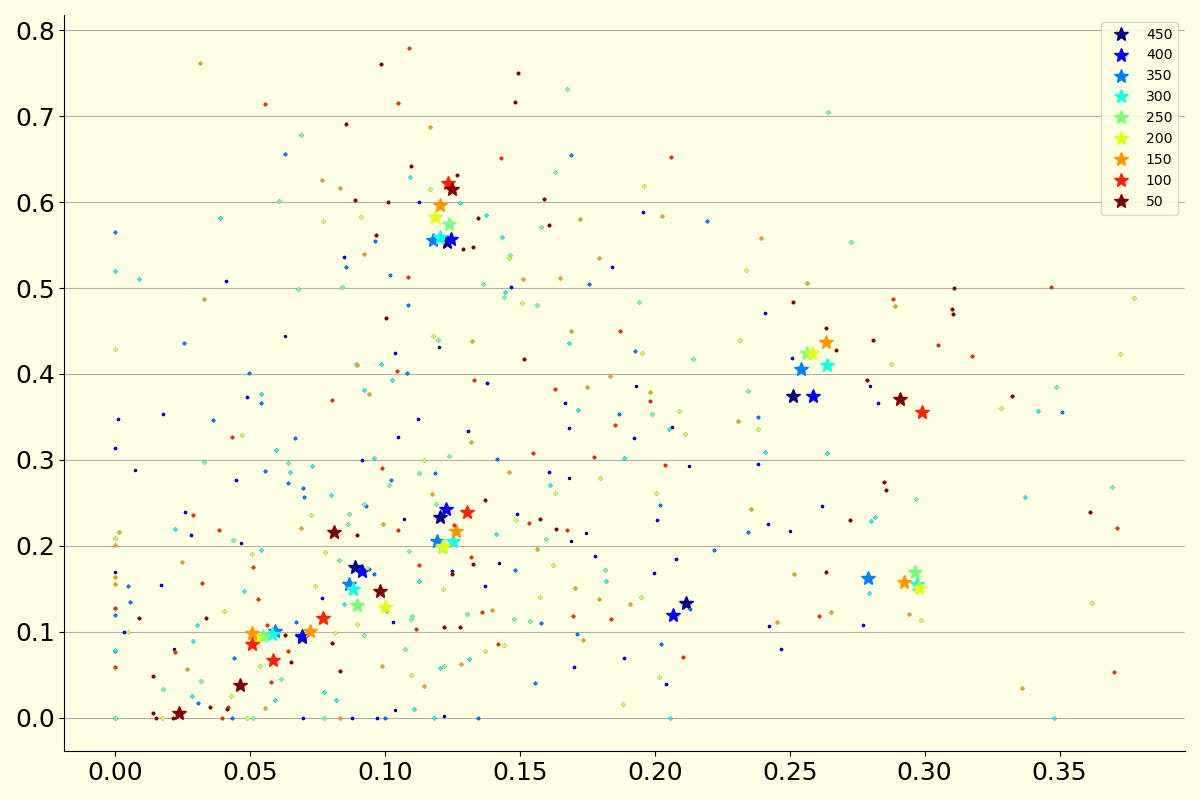

In [13]:
fig,ax = plt.subplots()

curRange = range(50,len(curData)+50,50)
curRange = curRange[::-1]
import matplotlib.cm as cm
cmap = cm.get_cmap('jet',len(curRange)) 
# for i,maxData in enumerate(curRange):
for i,maxData in enumerate(tqdm(curRange)):
    
    curColor = cmap(i)

    dataToUse = curData[:maxData]
    numClusters = 6
    clf = mixture.GaussianMixture(n_components=numClusters, n_init = 10,random_state=123, covariance_type="tied")

    clf.fit(dataToUse)


    dfMeans = pd.DataFrame(clf.means_)
    curSortIndex = dfMeans.cumsum(axis=1).sort_values(by=[0,1],ascending=False).index
    dfMeans = dfMeans.loc[curSortIndex].reset_index()
    dfMeans
    # curDim0 = clf.means_[:,0]
    # ax.plot(dfMeans.loc[:,0],'--')
    # ax.plot(dfMeans.loc[:,0]+dfMeans.loc[:,1],':')
    ax.plot(dfMeans.loc[:,3],dfMeans.loc[:,4],'*',color=curColor,label=maxData)
    ax.plot(dataToUse[:,3],dataToUse[:,4],'.',ms=3,color=curColor)
ax.legend()

In [14]:
# dfResClust0
# dfResClust0.loc[maxData] = dfMeans.loc[0]

(0.0, 1.0)

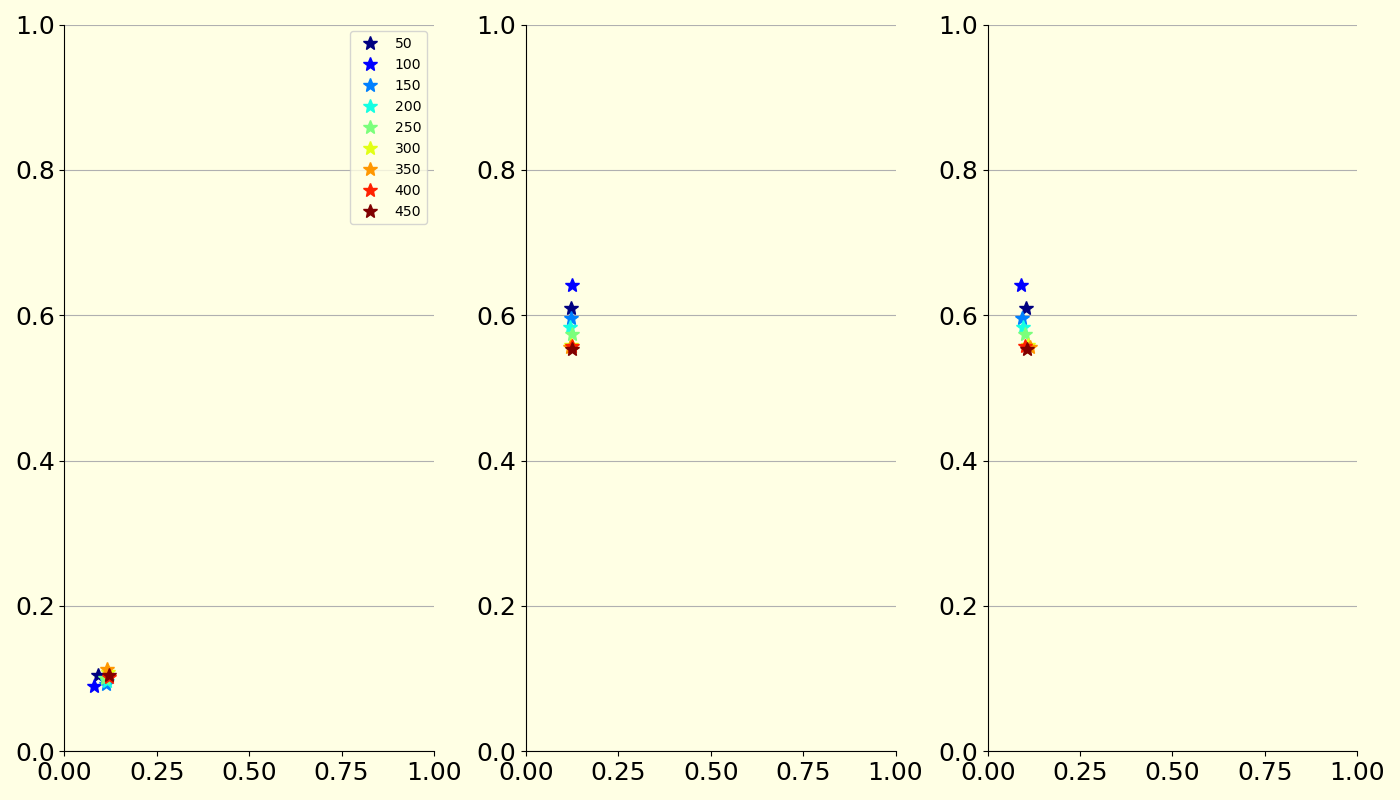

In [15]:
# fig,ax = plt.subplots()
fig,(ax,ax2,ax3) = plt.subplots(1,3,figsize=(14,8))

dlen =50 
curRange = range(50,len(curData)+dlen,dlen)
# dlen = 5
# curRange = range(150,200,dlen)
# curRange = curRange[::-1]
import matplotlib.cm as cm
cmap = cm.get_cmap('jet',len(curRange)) 

# clf = mixture.GaussianMixture(n_components=numClusters, n_init = 20, covariance_type="tied",warm_start=True)

dfResClust0 = pd.DataFrame(
    index=curRange,
    columns=np.arange(5)
)
dfResClustLast = pd.DataFrame(
    index=curRange,
    columns=np.arange(5)
)

for i,maxData in enumerate(curRange):
    
    curColor = cmap(i)

    dataToUse = curData[:maxData]
    # numClusters = 8
    numClusters = 6
    clf = mixture.GaussianMixture(n_components=numClusters, n_init = 30,random_state=123, covariance_type="tied")
    # clf = mixture.GaussianMixture(n_components=numClusters, n_init = 20, covariance_type="tied")

    clf.fit(dataToUse)


    dfMeans = pd.DataFrame(clf.means_)
    curSortIndex = dfMeans.cumsum(axis=1).sort_values(by=[0,1,2,3],ascending=False).index
    # curSortIndex = dfMeans.sort_values(by=[0,1,2,3],ascending=False).index
    dfMeans = dfMeans.loc[curSortIndex].reset_index(drop=True)

        
    dfResClust0.loc[maxData] = dfMeans.loc[0]
    
    curSortIndex = dfMeans.sort_values(by=[4],ascending=False).index
    # curSortIndex = dfMeans.sort_values(by=[0,1,2,3],ascending=False).index
    dfMeans = dfMeans.loc[curSortIndex].reset_index(drop=True)
    dfResClustLast.loc[maxData] = dfMeans.loc[0]
    

    # dfMeans
    # curDim0 = clf.means_[:,0]
    # ax.plot(dfMeans.loc[:,0],'--')
    ax.plot(dfMeans.loc[0,0],dfMeans.loc[0,1],'*',color=curColor,label=maxData)
    ax2.plot(dfMeans.loc[0,3],dfMeans.loc[0,4],'*',color=curColor,label=maxData)
    ax3.plot(dfMeans.loc[0,1],dfMeans.loc[0,4],'*',color=curColor,label=maxData)
ax.legend()

ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax2.set_xlim([0,1])
ax2.set_ylim([0,1])
ax3.set_xlim([0,1])
ax3.set_ylim([0,1])

In [16]:
# dfCrises.iloc[140:154]

In [17]:

dlen =1
curRange = range(10,len(curData)+dlen,dlen)
# dlen = 5
# curRange = range(150,200,dlen)
# curRange = curRange[::-1]


cmap = cm.get_cmap('jet',len(curRange)) 

# clf = mixture.GaussianMixture(n_components=numClusters, n_init = 20, covariance_type="tied",warm_start=True)

dfResClust0 = pd.DataFrame(
    index=curRange,
    columns=np.arange(5)
)
dfResClust1 = pd.DataFrame(
    index=curRange,
    columns=np.arange(5)
)
dfResClust3 = pd.DataFrame(
    index=curRange,
    columns=np.arange(5)
)
dfResClustLast = pd.DataFrame(
    index=curRange,
    columns=np.arange(5)
)
from tqdm import tqdm
for i,maxData in enumerate(tqdm(curRange)):
    
    curColor = cmap(i)

    dataToUse = curData[:maxData]
    # numClusters = 8
    numClusters = 6
    clf = mixture.GaussianMixture(n_components=numClusters, n_init = 100,random_state=0, covariance_type="tied")
    # clf = mixture.GaussianMixture(n_components=numClusters, n_init = 20, covariance_type="tied")

    clf.fit(dataToUse)


    dfMeans = pd.DataFrame(clf.means_)
    # curSortIndex = dfMeans.cumsum(axis=1).sort_values(by=[0,1,2,3],ascending=False).index
    curSortIndex = dfMeans.sort_values(by=[0],ascending=False).index
    # curSortIndex = dfMeans.sort_values(by=[0,1,2,3],ascending=False).index
    dfMeans = dfMeans.loc[curSortIndex].reset_index(drop=True)
    dfResClust0.loc[maxData] = dfMeans.loc[0]
    
    # curSortIndex = dfMeans.cumsum(axis=1).sort_values(by=[0,1,2,3],ascending=False).index
    curSortIndex = dfMeans.sort_values(by=[1],ascending=False).index
    # curSortIndex = dfMeans.sort_values(by=[0,1,2,3],ascending=False).index
    dfMeans = dfMeans.loc[curSortIndex].reset_index(drop=True)
    dfResClust1.loc[maxData] = dfMeans.loc[0]
    
    # curSortIndex = dfMeans.cumsum(axis=1).sort_values(by=[0,1,2,3],ascending=False).index
    curSortIndex = dfMeans.sort_values(by=[3],ascending=False).index
    # curSortIndex = dfMeans.sort_values(by=[0,1,2,3],ascending=False).index
    dfMeans = dfMeans.loc[curSortIndex].reset_index(drop=True)
    dfResClust3.loc[maxData] = dfMeans.loc[0]

    
    curSortIndex = dfMeans.sort_values(by=[4],ascending=False).index
    # curSortIndex = dfMeans.sort_values(by=[0,1,2,3],ascending=False).index
    dfMeans = dfMeans.loc[curSortIndex].reset_index(drop=True)
    dfResClustLast.loc[maxData] = dfMeans.loc[0]
    


  0%|          | 0/409 [00:00<?, ?it/s]

100%|██████████| 409/409 [19:22<00:00,  2.84s/it]


In [18]:
import matplotlib.cm as cm
# Sort clusters (and name)
cmap = cm.get_cmap('jet',numClusters)
cmapBar = cm.get_cmap('rainbow',5)


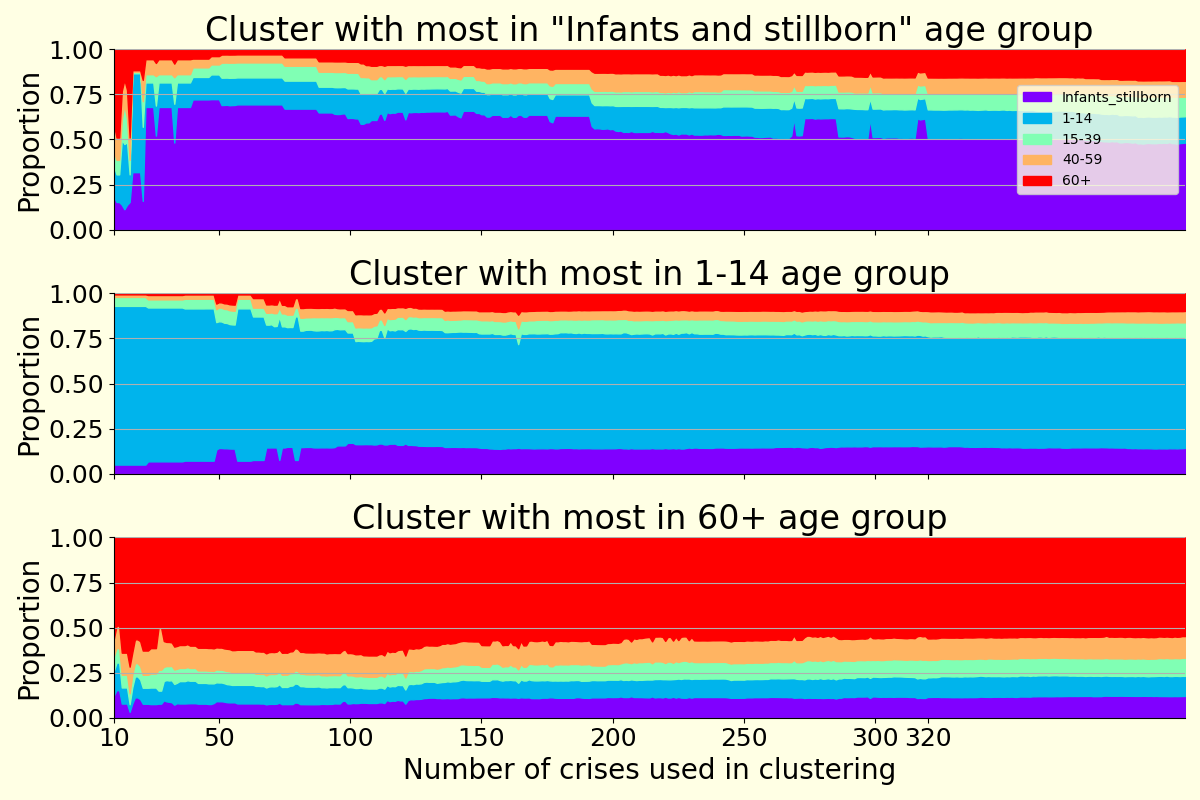

In [19]:
fig,(ax1,ax2,ax3) = plt.subplots(3,1,sharex=True,sharey=True)




dfToPlot = dfResClust0.cumsum(axis=1)
dfToPlot = dfToPlot.astype('float')
ax = ax1 
ax.fill_between(curRange,dfToPlot[0],color=cmapBar(0),label=ageGroupNames[0])
ax.fill_between(curRange,dfToPlot[1],dfToPlot[0],color=cmapBar(1/5),label=ageGroupNames[1])
ax.fill_between(curRange,dfToPlot[2],dfToPlot[1],color=cmapBar(2/5),label=ageGroupNames[2])
ax.fill_between(curRange,dfToPlot[3],dfToPlot[2],color=cmapBar(3/5),label=ageGroupNames[3])
ax.fill_between(curRange,dfToPlot[4],dfToPlot[3],color=cmapBar(4/5),label=ageGroupNames[4])

dfToPlot = dfResClust1.cumsum(axis=1)
dfToPlot = dfToPlot.astype('float')
ax = ax2
ax.fill_between(curRange,dfToPlot[0],color=cmapBar(0),label=ageGroupNames[0])
ax.fill_between(curRange,dfToPlot[1],dfToPlot[0],color=cmapBar(1/5),label=ageGroupNames[1])
ax.fill_between(curRange,dfToPlot[2],dfToPlot[1],color=cmapBar(2/5),label=ageGroupNames[2])
ax.fill_between(curRange,dfToPlot[3],dfToPlot[2],color=cmapBar(3/5),label=ageGroupNames[3])
ax.fill_between(curRange,dfToPlot[4],dfToPlot[3],color=cmapBar(4/5),label=ageGroupNames[4])

dfToPlot = dfResClustLast.cumsum(axis=1)
dfToPlot = dfToPlot.astype('float')
ax = ax3
ax.fill_between(curRange,dfToPlot[0],color=cmapBar(0))
ax.fill_between(curRange,dfToPlot[1],dfToPlot[0],color=cmapBar(1/5))
ax.fill_between(curRange,dfToPlot[2],dfToPlot[1],color=cmapBar(2/5))
ax.fill_between(curRange,dfToPlot[3],dfToPlot[2],color=cmapBar(3/5))
ax.fill_between(curRange,dfToPlot[4],dfToPlot[3],color=cmapBar(4/5))

ax.set_xlim([curRange[0],curRange[-1]])
ax.set_ylim([0,1])
ax.set_yticks([0,0.25,0.5,0.75,1])
ax.set_xticks([10,50,100,150,200,250,300,320])

ax1.set_title('Cluster with most in "Infants and stillborn" age group')
ax2.set_title('Cluster with most in 1-14 age group')
ax3.set_title('Cluster with most in 60+ age group')

ax1.set_ylabel('Proportion')
ax2.set_ylabel('Proportion')
ax3.set_ylabel('Proportion')


ax1.legend(loc='center right')

ax3.set_xlabel('Number of crises used in clustering')

fig.tight_layout()

if saveFigures:
    fig.savefig(pathFigs + 'Clustering_NumCrisesSensitivity')


# GMM fitting used

In [20]:

dataToUse = curData[:150]
# numClusters = 8
numClusters = 6
gmm = mixture.GaussianMixture(n_components=numClusters, n_init = 100,random_state=1, covariance_type="tied")

gmm.fit(dataToUse)


GaussianMixture(covariance_type='tied', n_components=6, n_init=100,
                random_state=1)

In [21]:

dfMeans = pd.DataFrame(gmm.means_)

# # Sort clusters by the sum of first and second columns (i.e. stillborn+0+1-14)
# curSortIndex = dfMeans[[0,1]].sum(axis=1).sort_values(ascending=False).index
# New method for sorting in a visually pleasing way: Cumulative by age-groups, rounded to two decimals, first two groups only
curSortIndex = dfMeans.cumsum(axis=1).round(2).sort_values(by=[1,0],ascending=False).index
dfMeans = dfMeans.loc[curSortIndex].reset_index(drop=True)

# Name according to current order
curClusters = np.arange(numClusters)
clusterNameDict = dict(zip(dfMeans.index.values,[chr(65+x) for x in curClusters])) # chr(65) is 'A', chr(66) is 'B' ...

clusterNumDict = dict(zip(dfMeans.index.values,curClusters)) # chr(65) is 'A', chr(66) is 'B' ...
clusterNameDict

{0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F'}

In [22]:

dfMeans = pd.DataFrame(gmm.means_)

# # Sort clusters by the sum of first and second columns (i.e. stillborn+0+1-14)
# curSortIndex = dfMeans[[0,1]].sum(axis=1).sort_values(ascending=False).index
# New method for sorting in a visually pleasing way: Cumulative by age-groups, rounded to two decimals, first two groups only
curSortIndex = dfMeans.cumsum(axis=1).round(2).sort_values(by=[1,0],ascending=False).index

dfMeans = dfMeans.loc[curSortIndex].reset_index(drop=True)

# New ordering, December 2023
orderVal = dfMeans.iloc[:,0] + dfMeans.iloc[:,1] * 0.5 - dfMeans.iloc[:,-1]
newSortIndex = 5 - np.argsort(orderVal)
dfMeans = dfMeans.loc[newSortIndex].reset_index(drop=True)



# Name according to current order
curClusters = np.arange(numClusters)
clusterNameDict = dict(zip(dfMeans.index.values,[chr(65+x) for x in curClusters])) # chr(65) is 'A', chr(66) is 'B' ...

clusterNumDict = dict(zip(dfMeans.index.values,curClusters)) # chr(65) is 'A', chr(66) is 'B' ...
clusterNameDict

{0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F'}

In [23]:
# curSortIndex # [0, 2, 1, 4, 3, 5]

In [24]:

# dfMeans.columns = ageGroupNames

# # dfMeans = dfMeans.rename(columns={'Infants and stillborn': 'Infants and\nstillborn'})
# dfMeans = dfMeans.rename(columns={'Infants_stillborn': 'Infants and\nstillborn'})

# fig,ax = plt.subplots(figsize=(12,5))
# (dfMeans * 100).plot.bar(ax=ax,stacked=True,width=0.8,cmap=cmapBar)
# ax.set_axisbelow(True)
# ax.set_ylim([0,100])
# ax.legend(bbox_to_anchor=(1.05,0.5),loc='center left',fontsize=16)
# ax.set_xlabel('Cluster identifier',fontsize=16)
# ax.set_ylabel('Proportion of excess mortality',fontsize=16)
# from matplotlib.ticker import FormatStrFormatter
# ax.yaxis.set_major_formatter(FormatStrFormatter('%d%%'))
# ax.tick_params(axis='y',labelsize=12)

# plt.xticks(rotation=0)

# K-means

In [25]:
from sklearn.cluster import KMeans


dataToUse = curData[:150]
# numClusters = 8
numClusters = 6

kmeans = KMeans(init="k-means++", n_clusters=numClusters, n_init=100, random_state=1)
# gmm = mixture.GaussianMixture(n_components=numClusters, n_init = 100,random_state=1, covariance_type="tied")
kmeans.fit(dataToUse)
# gmm.fit(dataToUse)

kmeansLabels = kmeans.predict(curData)


In [26]:
kmeans.cluster_centers_

dfK = pd.DataFrame(kmeans.cluster_centers_)

# # Sort clusters by the sum of first and second columns (i.e. stillborn+0+1-14)
# curSortIndex = dfK[[0,1]].sum(axis=1).sort_values(ascending=False).index
# New method for sorting in a visually pleasing way: Cumulative by age-groups, rounded to two decimals, first two groups only
curSortIndex = dfK.cumsum(axis=1).round(2).sort_values(by=[1,0],ascending=False).index
dfK = dfK.loc[curSortIndex].reset_index(drop=True)

# New ordering, December 2023
orderVal = dfK.iloc[:,0] + dfK.iloc[:,1] * 0.5 - dfK.iloc[:,-1]
newSortIndexKmeans = 5 - np.argsort(orderVal)
dfK = dfK.loc[newSortIndexKmeans].reset_index(drop=True)


# Name according to current order
curClusters = np.arange(numClusters)
clusterNameDictK = dict(zip(dfK.index.values,[chr(65+x) for x in curClusters])) # chr(65) is 'A', chr(66) is 'B' ...

clusterNumDictK = dict(zip(dfK.index.values,curClusters)) # chr(65) is 'A', chr(66) is 'B' ...
clusterNameDictK

{0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F'}

In [27]:
# kmeansSortDict1 = dict(zip(np.arange(numClusters),curSortIndex))
# kmeansSortDict2 = newSortIndexKmeans.to_dict()

# kmeansLabelsNew = [kmeansSortDict1[x] for x in kmeansLabels]
# kmeansLabelsNew = [kmeansSortDict2[x] for x in kmeansLabelsNew]
# # kmeansLabelsNew

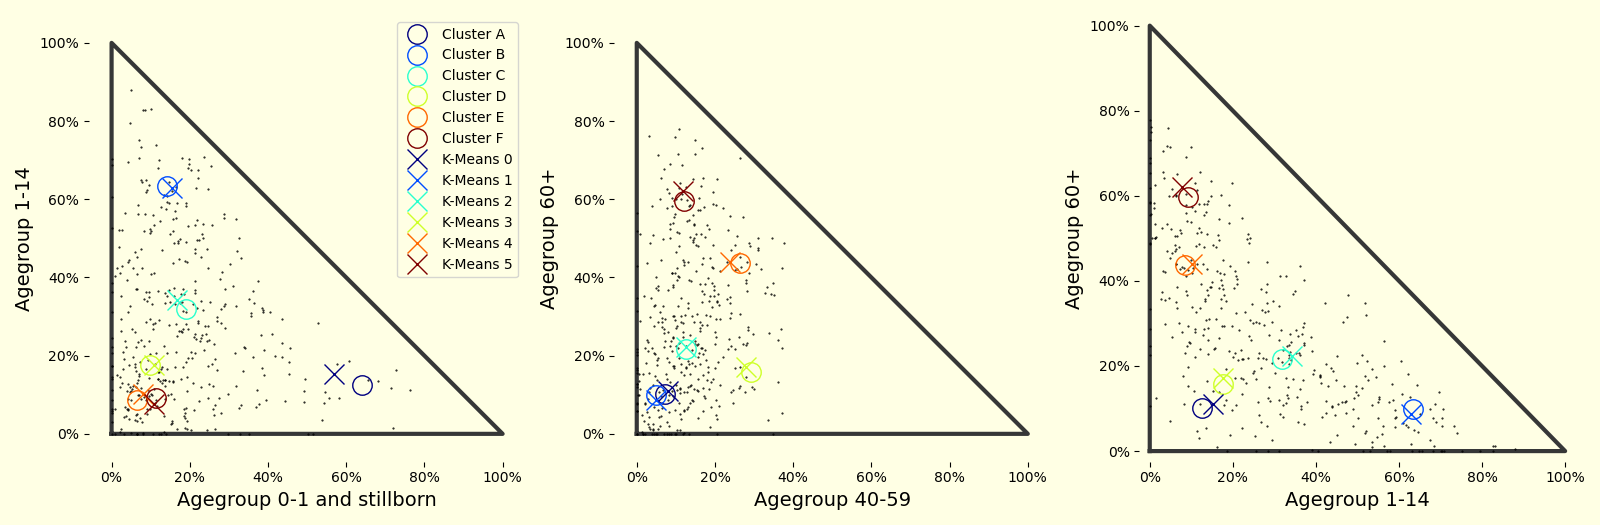

In [28]:


fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(16,5.25))

ax1.axis('equal')
ax2.axis('equal')


for i,r in dfCrises.iterrows():

    (cur1,cur2,cur3,cur4,cur5) = (100*curData[i])

    # curLabel = r.Amt[:4]+', '+str(r.DayWithMostBurials.year)
    curLabel = r.Amt[:4]+', '+str(r.DayWithMostDeaths.year)
    
    # curColor = cmap(clusterNumDict[r.Cluster]/numClusters)
    # curColor = cmap(clusterNumDict[invMap[r.Cluster]]/numClusters)
    curColor='k'
    
    
    ax1.plot(cur1,cur2,'.',ms=1,color=curColor)
    ax2.plot(cur4,cur5,'.',ms=1,color=curColor)
    ax3.plot(cur2,cur5,'.',ms=1,color=curColor)

labelFontSize = 14


clusterNum = 0
for i,clusterNum in enumerate(range(gmm.means_.shape[0])):
    # curMean = gmm.means_[clusterNum,:]
    
    curMean = dfMeans.iloc[clusterNum,:]
    
    mea1,mea2,mea3,mea4,mea5 = (100*curMean)

    curColor = cmap(i/numClusters)
    curLabel = 'Cluster '+clusterNameDict[clusterNum]

    ax1.plot(mea1,mea2,'o',color=curColor,mfc='none',markersize=14,label=curLabel)
    ax2.plot(mea4,mea5,'o',color=curColor,mfc='none',markersize=14,label=curLabel)
    ax3.plot(mea2,mea5,'o',color=curColor,mfc='none',markersize=14,label=curLabel)
    
for i,clusterNum in enumerate(range(len(dfK))):
    # curMean = cluster_centers[clusterNum,:]
    curMean = dfK.iloc[clusterNum,:]
    
    mea1,mea2,mea3,mea4,mea5 = (100*curMean)

    curColor = cmap(i/numClusters)
    curLabel = 'K-Means '+str(clusterNum)

    ax1.plot(mea1,mea2,'x',color=curColor,mfc='none',markersize=14,label=curLabel)
    ax2.plot(mea4,mea5,'x',color=curColor,mfc='none',markersize=14,label=curLabel)
    ax3.plot(mea2,mea5,'x',color=curColor,mfc='none',markersize=14,label=curLabel)

ax1.legend()
for ax in [ax1,ax2,ax3]:
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    # ax.plot([0,1,0,0],[0,0,1,0],color='xkcd:dark grey',zorder=0)
    ax.plot([0,100,0,0],[0,0,100,0],color='xkcd:dark grey',zorder=0)

    ax.xaxis.set_tick_params(which='both', labelbottom=True,labelsize=10)
    ax.yaxis.set_tick_params(which='both', labelbottom=True,labelsize=10)
    
    # ax.set_xlim([-0.01,1.01])
    # ax.set_ylim([-0.01,1.01])
    ax.set_xlim([-2.5,102.5])
    ax.set_ylim([-2.5,102.5])


    import matplotlib.ticker as ticker
    ax.xaxis.set_major_formatter(ticker.PercentFormatter())
    ax.yaxis.set_major_formatter(ticker.PercentFormatter())

    ax.grid(False)

ax1.set_xlabel('Agegroup 0-1 and stillborn',fontsize=labelFontSize)
ax1.set_ylabel('Agegroup 1-14',fontsize=labelFontSize)
ax2.set_xlabel('Agegroup 40-59',fontsize=labelFontSize)
ax2.set_ylabel('Agegroup 60+',fontsize=labelFontSize)

ax3.set_xlabel('Agegroup 1-14',fontsize=labelFontSize)
ax3.set_ylabel('Agegroup 60+',fontsize=labelFontSize)


fig.tight_layout()

if saveFigures:
    fig.savefig(pathFigs +'Supplementary_KmeansVsGaussian')

(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'A'),
  Text(1, 0, 'B'),
  Text(2, 0, 'C'),
  Text(3, 0, 'D'),
  Text(4, 0, 'E'),
  Text(5, 0, 'F')])

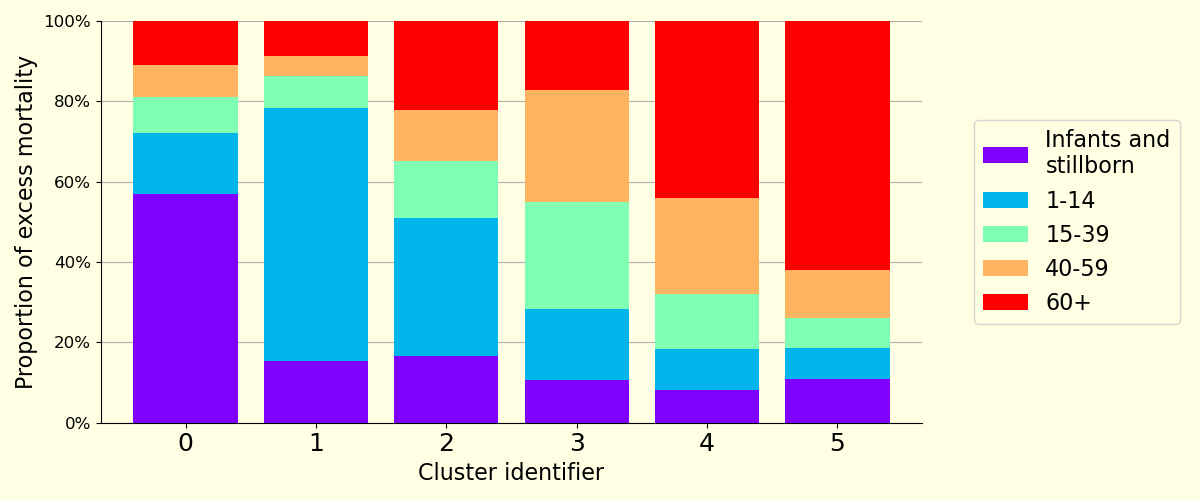

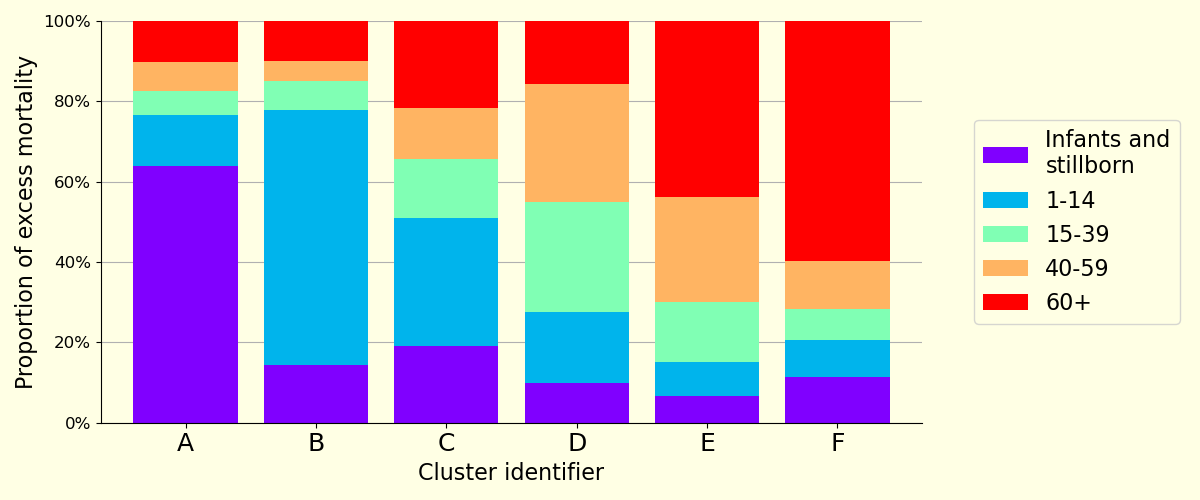

In [29]:

dfK.columns = ageGroupNames

# dfK = dfK.rename(columns={'Infants and stillborn': 'Infants and\nstillborn'})
dfK = dfK.rename(columns={'Infants_stillborn': 'Infants and\nstillborn'})

fig,ax = plt.subplots(figsize=(12,5))
(dfK * 100).plot.bar(ax=ax,stacked=True,width=0.8,cmap=cmapBar)
ax.set_axisbelow(True)
ax.set_ylim([0,100])
ax.legend(bbox_to_anchor=(1.05,0.5),loc='center left',fontsize=16)
ax.set_xlabel('Cluster identifier',fontsize=16)
ax.set_ylabel('Proportion of excess mortality',fontsize=16)
from matplotlib.ticker import FormatStrFormatter
ax.yaxis.set_major_formatter(FormatStrFormatter('%d%%'))
ax.tick_params(axis='y',labelsize=12)

plt.xticks(rotation=0)

dfMeans.columns = ageGroupNames

# dfMeans = dfMeans.rename(columns={'Infants and stillborn': 'Infants and\nstillborn'})
dfMeans = dfMeans.rename(columns={'Infants_stillborn': 'Infants and\nstillborn'})

fig,ax = plt.subplots(figsize=(12,5))
(dfMeans * 100).plot.bar(ax=ax,stacked=True,width=0.8,cmap=cmapBar)
ax.set_axisbelow(True)
ax.set_ylim([0,100])
ax.legend(bbox_to_anchor=(1.05,0.5),loc='center left',fontsize=16)
ax.set_xlabel('Cluster identifier',fontsize=16)
ax.set_ylabel('Proportion of excess mortality',fontsize=16)
from matplotlib.ticker import FormatStrFormatter
ax.yaxis.set_major_formatter(FormatStrFormatter('%d%%'))
ax.tick_params(axis='y',labelsize=12)

ax.set_xticklabels([clusterNameDict[x] for x in dfMeans.index.values])

plt.xticks(rotation=0)

In [30]:
# clusterNameDictK[0]

In [31]:
# dfCrisesFinal['Kmeans'] = [clusterNameDictK[x] for x in kmeansLabels]
dfCrises['Kmeans'] = [clusterNameDictK[x] for x in kmeansLabels]

In [32]:
# display(dfCrisesFinal.groupby(['Cluster','Kmeans']).size().to_frame())
# # 1 + 2 +3 + 1+6+6+4+4+2+1
# display(dfCrisesFinal.groupby(['Kmeans','Cluster']).size().to_frame())
# display(dfCrisesFinal[dfCrisesFinal.Group != 'None'].groupby(['Kmeans','Cluster']).size().to_frame())
# display(dfCrisesFinal[(dfCrisesFinal.Group != 'None') & ~(dfCrisesFinal.Group.str.contains('Poten'))].groupby(['Kmeans','Cluster']).size().to_frame())
# display(dfCrisesFinal[dfCrisesFinal.Group != 'None'].groupby(['Kmeans','Cluster']).size().to_frame())
# display(dfCrisesFinal[dfCrisesFinal.Group.str.contains('war')].groupby(['Kmeans','Cluster']).size().to_frame())

# 1+6+4+2+2+4+3+1+6+1

# Test with MeanShift

In [33]:
import matplotlib.cm as cm
# Sort clusters (and name)
cmap = cm.get_cmap('jet',numClusters)
cmapBar = cm.get_cmap('rainbow',5)


In [34]:

from sklearn.cluster import MeanShift, estimate_bandwidth

In [35]:

dataToUse = curData[:150]
dataToUse = curData
bandwidth = estimate_bandwidth(dataToUse, quantile=0.1)
# bandwidth = 0.175
bandwidth = 0.2
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(dataToUse)
labels = ms.labels_
cluster_centers = ms.cluster_centers_
labels

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

print("number of estimated clusters : %d" % n_clusters_)

number of estimated clusters : 5


In [36]:
allLabels = ms.predict(curData)
dfCrises['MeanShiftLabel'] = allLabels

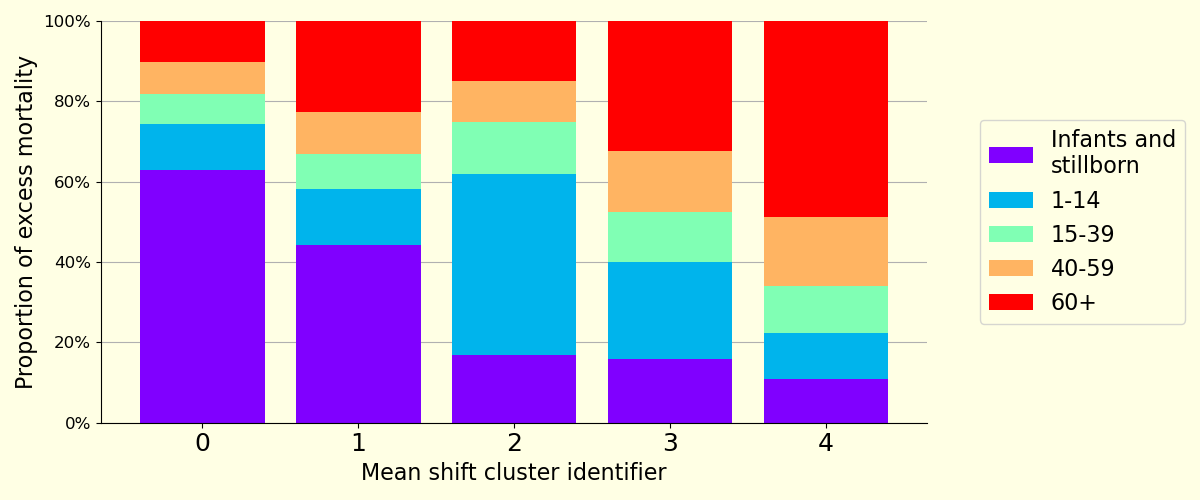

In [37]:
cluster_centers

testMeans = pd.DataFrame(cluster_centers)

# # Sort clusters by the sum of first and second columns (i.e. stillborn+0+1-14)
# curSortIndex = testMeans[[0,1]].sum(axis=1).sort_values(ascending=False).index
# New method for sorting in a visually pleasing way: Cumulative by age-groups, rounded to two decimals, first two groups only
curSortIndex = testMeans.cumsum(axis=1).round(2).sort_values(by=[1,0],ascending=False).index
testMeans = testMeans.loc[curSortIndex].reset_index(drop=True)



# New ordering, December 2023
orderVal = testMeans.iloc[:,0] + testMeans.iloc[:,1] * 0.5 - testMeans.iloc[:,-1]
newSortIndex = np.argsort(orderVal)[::-1]
testMeans = testMeans.loc[newSortIndex].reset_index(drop=True)


# # New ordering, December 2023
# orderVal = testMeans.iloc[:,0] + testMeans.iloc[:,1] * 0.25 - testMeans.iloc[:,-1]
# orderVal = testMeans.iloc[:,0] + testMeans.iloc[:,1] * 0.75 
# orderVal = testMeans.iloc[:,0] 
# # newSortIndex = 5 - np.argsort(orderVal)
# # newSortIndex = np.argsort(orderVal[::-1])
# testMeans = testMeans.loc[newSortIndex].reset_index(drop=True)


testMeans.columns = ageGroupNames

# testMeans = testMeans.rename(columns={'Infants and stillborn': 'Infants and\nstillborn'})
testMeans = testMeans.rename(columns={'Infants_stillborn': 'Infants and\nstillborn'})

fig,ax = plt.subplots(figsize=(12,5))
(testMeans * 100).plot.bar(ax=ax,stacked=True,width=0.8,cmap=cmapBar)
ax.set_axisbelow(True)
ax.set_ylim([0,100])
ax.legend(bbox_to_anchor=(1.05,0.5),loc='center left',fontsize=16)
ax.set_xlabel('Mean shift cluster identifier',fontsize=16)
ax.set_ylabel('Proportion of excess mortality',fontsize=16)
from matplotlib.ticker import FormatStrFormatter
ax.yaxis.set_major_formatter(FormatStrFormatter('%d%%'))
ax.tick_params(axis='y',labelsize=12)

plt.xticks(rotation=0)

# ax.set_xticklabels([clusterNameDict[x] for x in dfMeans.index.values])
# fig.suptitle('Using MeanShift')
fig.tight_layout()

if saveFigures:
    fig.savefig(pathFigs+'Supplementary_MeanShiftClusters')

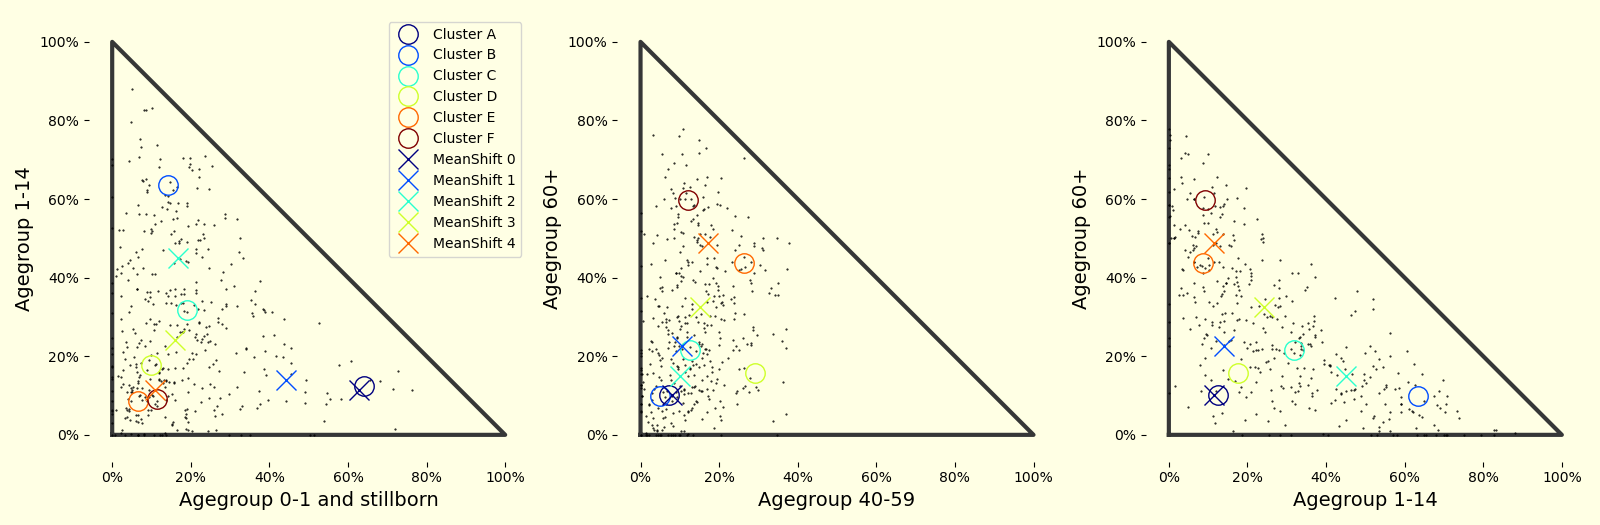

In [38]:


# fig,(ax1,ax2) = plt.subplots(1,2,figsize=(11,5.25))
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(16,5.25))

ax1.axis('equal')
ax2.axis('equal')
ax3.axis('equal')


for i,r in dfCrises.iterrows():

    (cur1,cur2,cur3,cur4,cur5) = (100*curData[i])

    # curLabel = r.Amt[:4]+', '+str(r.DayWithMostBurials.year)
    curLabel = r.Amt[:4]+', '+str(r.DayWithMostDeaths.year)
    
    # curColor = cmap(clusterNumDict[r.Cluster]/numClusters)
    # curColor = cmap(clusterNumDict[invMap[r.Cluster]]/numClusters)
    curColor='k'
    
    
    ax1.plot(cur1,cur2,'.',color=curColor,ms=1)
    ax2.plot(cur4,cur5,'.',color=curColor,ms=1)
    ax3.plot(cur2,cur5,'.',color=curColor,ms=1)

labelFontSize = 14


clusterNum = 0
for i,clusterNum in enumerate(range(gmm.means_.shape[0])):
    # curMean = gmm.means_[clusterNum,:]
    curMean = dfMeans.iloc[clusterNum,:]
    
    mea1,mea2,mea3,mea4,mea5 = (100*curMean)

    curColor = cmap(i/numClusters)
    curLabel = 'Cluster '+clusterNameDict[clusterNum]

    ax1.plot(mea1,mea2,'o',color=curColor,mfc='none',markersize=14,label=curLabel)
    ax2.plot(mea4,mea5,'o',color=curColor,mfc='none',markersize=14,label=curLabel)
    ax3.plot(mea2,mea5,'o',color=curColor,mfc='none',markersize=14,label=curLabel)
    
for i,clusterNum in enumerate(range(len(cluster_centers))):
    # curMean = cluster_centers[clusterNum,:]
    curMean = testMeans.iloc[clusterNum,:]
    
    mea1,mea2,mea3,mea4,mea5 = (100*curMean)

    # curColor = cmap((7/8)*i/numClusters)
    # curColor = cmap((8/6)*i/numClusters)
    # curColor = cmap(i/numClusters)
    curColor = cmap((6/n_clusters_)*i/numClusters)
    curLabel = 'MeanShift '+str(clusterNum)

    ax1.plot(mea1,mea2,'x',color=curColor,mfc='none',markersize=14,label=curLabel)
    ax2.plot(mea4,mea5,'x',color=curColor,mfc='none',markersize=14,label=curLabel)
    ax3.plot(mea2,mea5,'x',color=curColor,mfc='none',markersize=14,label=curLabel)

ax1.legend()
for ax in [ax1,ax2,ax3]:
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    # ax.plot([0,1,0,0],[0,0,1,0],color='xkcd:dark grey',zorder=0)
    ax.plot([0,100,0,0],[0,0,100,0],color='xkcd:dark grey',zorder=0)

    ax.xaxis.set_tick_params(which='both', labelbottom=True,labelsize=10)
    ax.yaxis.set_tick_params(which='both', labelbottom=True,labelsize=10)
    
    # ax.set_xlim([-0.01,1.01])
    # ax.set_ylim([-0.01,1.01])
    ax.set_xlim([-2.5,102.5])
    ax.set_ylim([-2.5,102.5])


    import matplotlib.ticker as ticker
    ax.xaxis.set_major_formatter(ticker.PercentFormatter())
    ax.yaxis.set_major_formatter(ticker.PercentFormatter())

    ax.grid(False)

fig.tight_layout()
    
ax1.set_xlabel('Agegroup 0-1 and stillborn',fontsize=labelFontSize)
ax1.set_ylabel('Agegroup 1-14',fontsize=labelFontSize)
ax2.set_xlabel('Agegroup 40-59',fontsize=labelFontSize)
ax2.set_ylabel('Agegroup 60+',fontsize=labelFontSize)

ax3.set_xlabel('Agegroup 1-14',fontsize=labelFontSize)
ax3.set_ylabel('Agegroup 60+',fontsize=labelFontSize)


fig.tight_layout()

if saveFigures:
    fig.savefig(pathFigs +'Supplementary_MeanShiftVsGaussian')

# Compare results of GMM, kmeans and meanshift

In [45]:
dfCrises.columns

Index(['Amt', 'Start', 'End', 'NumberOfDays', 'DayWithMostDeaths', 'Excess',
       'ExcessPct', 'GenderRatio', 'TimeOfYear', 'Season',
       'PopulationEstimate', 'Exc_Infants_stillborn', 'Exc_1-14', 'Exc_15-39',
       'Exc_40-59', 'Exc_60+', 'Pct_Infants_stillborn', 'Pct_1-14',
       'Pct_15-39', 'Pct_40-59', 'Pct_60+', 'DataSum_Infants_stillborn',
       'DataSum_1-14', 'DataSum_15-39', 'DataSum_40-59', 'DataSum_60+',
       'Baseline_Infants_stillborn', 'Baseline_1-14', 'Baseline_15-39',
       'Baseline_40-59', 'Baseline_60+', 'FracAll_Infants_stillborn',
       'FracAll_1-14', 'FracAll_15-39', 'FracAll_40-59', 'FracAll_60+',
       'AgeSplitSumExc', 'Kmeans', 'MeanShiftLabel'],
      dtype='object')

In [46]:
# Compare results with GMM clustering results

finalResultsFilename = 'AllCrises_NonSmoothed_Years12_Threshold3_LowerThreshold2_MaxDaysBelow7_minLength0_minCount50_Clustered_Grouped'
dfCrisesFinal = pd.read_csv(pathData+finalResultsFilename+'.csv')


array([2, 4, 4, 4, 4, 5, 4, 4, 0, 1, 4, 2, 1, 0, 0, 0, 5, 0, 2, 1, 2, 3,
       5, 1, 4, 3, 4, 3, 5, 1, 1, 1, 5, 1, 1, 5, 5, 1, 1, 3, 2, 1, 0, 4,
       0, 1, 3, 1, 1, 5, 3, 4, 1, 0, 1, 0, 0, 0, 5, 4, 4, 2, 5, 1, 0, 0,
       0, 5, 4, 0, 5, 0, 4, 4, 3, 5, 0, 0, 5, 5, 0, 4, 0, 0, 0, 5, 0, 3,
       1, 0, 1, 0, 2, 2, 5, 0, 1, 4, 5, 2, 1, 2, 4, 3, 1, 3, 4, 3, 5, 0,
       0, 4, 2, 1, 5, 0, 5, 4, 1, 0, 0, 4, 1, 5, 2, 5, 1, 1, 2, 1, 0, 4,
       1, 4, 4, 0, 3, 0, 5, 2, 4, 1, 0, 2, 4, 0, 0, 3, 5, 5, 4, 3, 5, 3,
       5, 4, 3, 0, 1, 5, 0, 3, 4, 0, 0, 0, 4, 5, 4, 0, 5, 5, 1, 4, 2, 3,
       0, 4, 3, 5, 5, 4, 0, 4, 5, 1, 4, 1, 1, 5, 2, 5, 3, 0, 2, 0, 5, 4,
       0, 4, 3, 5, 4, 1, 2, 0, 2, 5, 0, 1, 0, 4, 4, 2, 0, 4, 1, 3, 1, 1,
       3, 3, 5, 1, 0, 0, 1, 5, 1, 0, 4, 4, 5, 0, 0, 4, 0, 4, 5, 2, 5, 3,
       5, 1, 1, 4, 5, 5, 3, 0, 4, 0, 2, 3, 2, 4, 5, 0, 4, 4, 3, 5, 0, 3,
       2, 5, 1, 3, 1, 0, 1, 5, 0, 0, 5, 4, 5, 4, 5, 0, 1, 5, 3, 2, 1, 0,
       5, 1, 0, 0, 0, 3, 1, 0, 4, 5, 4, 0, 0, 4, 4,

In [84]:
# dfCrisesFinal['Kmeans'] = dfCrises['Kmeans']
dfCrisesFinal['Kmeans'] = kmeansLabels
# dfCrisesFinal['Kmeans'] = kmeansLabelsNew
dfCrisesFinal['MeanShiftLabel'] = dfCrises['MeanShiftLabel']

In [86]:
# dfCrisesFinal[['Cluster','Kmeans','MeanShiftLabel','Group']]

# display(dfCrisesFinal[dfCrisesFinal['Group'].str.contains('')].groupby(['Cluster','Kmeans']).count())
# dfCrisesFinal.groupby(['Cluster','Kmeans']).count()
dfCrisesFinal.groupby(['Kmeans','Cluster']).count()
# dfCrisesFinal.groupby(['Cluster','MeanShiftLabel']).count()

Amt  Start  End  NumberOfDays  DayWithMostDeaths  Excess  \
Kmeans Cluster                                                             
0      A          5      5    5             5                  5       5   
       C        105    105  105           105                105     105   
       E          2      2    2             2                  2       2   
1      E         66     66   66            66                 66      66   
       F          1      1    1             1                  1       1   
2      C          4      4    4             4                  4       4   
       D         31     31   31            31                 31      31   
       F          2      2    2             2                  2       2   
3      B         25     25   25            25                 25      25   
       C         14     14   14            14                 14      14   
       E          1      1    1             1                  1       1   
4      C         11     11   11            11                 11      11   
       E         18     18   18            18                 18      18   
       F         51     51   51            51                 51      51   
5      A         70     70   70            70                 70      70   
       C         12     12   12            12                 12      12   

                ExcessPct  GenderRatio  TimeOfYear  Season  ...  FracAll_60+  \
Kmeans Cluster                                              ...                
0      A                5            5           5       5  ...            5   
       C              105          105         105     105  ...          105   
       E                2            2           2       2  ...            2   
1      E               66           66          66      66  ...           66   
       F                1            1           1       1  ...            1   
2      C                4            4           4       4  ...            4   
       D               31           31          31      31  ...           31   
       F                2            2           2       2  ...            2   
3      B               25           25          25      25  ...           25   
       C               14           14          14      14  ...           14   
       E                1            1           1       1  ...            1   
4      C               11           11          11      11  ...           11   
       E               18           18          18      18  ...           18   
       F               51           51          51      51  ...           51   
5      A               70           70          70      70  ...           70   
       C               12           12          12      12  ...           12   

                AgeSplitSumExc  ClusterA_Prob  ClusterB_Prob  ClusterC_Prob  \
Kmeans Cluster                                                                
0      A                     5              5              5              5   
       C                   105            105            105            105   
       E                     2              2              2              2   
1      E                    66             66             66             66   
       F                     1              1              1              1   
2      C                     4              4              4              4   
       D                    31             31             31             31   
       F                     2              2              2              2   
3      B                    25             25             25             25   
       C                    14             14             14             14   
       E                     1              1              1              1   
4      C                    11             11             11             11   
       E                    18             18             18             18   
       F             

In [92]:
len(dfCrisesFinal)

418

In [97]:
kmeansToCluster = {
    0:'C',
    1:'E',
    2:'D',
    3:'B',
    4:'F',
    5:'A',
}

# [kmeansToCluster[x] for x in  dfCrisesFinal['Kmeans']]
testdf = dfCrisesFinal[dfCrisesFinal['Cluster'] != dfCrisesFinal['Kmeans'].apply(lambda x: kmeansToCluster[x])]
testdf[testdf.Group == 'None']

,Amt,Start,End,NumberOfDays,DayWithMostDeaths,Excess,ExcessPct,GenderRatio,TimeOfYear,Season,...,Cluster,ClusterA_Prob,ClusterB_Prob,ClusterC_Prob,ClusterD_Prob,ClusterE_Prob,ClusterF_Prob,Group,Kmeans,MeanShiftLabel
25,Staden København,1857-08-06,1857-10-05,60,1857-08-12,393,65.0,0.547358,Q3,Summer,...,C,0.0000,0.0005,0.9994,0.0001,0.0000,0.0000,None,3,3
27,Staden København,1852-08-04,1852-10-14,71,1852-09-09,390,55.0,0.514027,Q3,Fall,...,C,0.0002,0.0303,0.9695,0.0000,0.0000,0.0000,None,3,3
58,Århus Amt,1888-05-16,1888-07-24,69,1888-05-19,211,39.0,0.476190,Q2,Spring,...,C,0.3203,0.0000,0.6797,0.0000,0.0000,0.0000,None,5,2
68,Ringkøbing Amt,1837-02-03,1837-04-01,57,1837-02-09,189,98.0,0.519685,Q1,Winter,...,C,0.0000,0.0000,0.5554,0.0000,0.4421,0.0025,None,4,1
73,Staden København,1894-01-02,1894-01-19,17,1894-01-08,181,60.0,0.511435,Q1,Winter,...,C,0.0000,0.0000,0.6372,0.0001,0.1400,0.2227,None,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
397,Sorø Amt,1867-01-23,1867-02-13,21,1867-01-23,51,53.0,0.476510,Q1,Winter,...,C,0.0000,0.0000,0.6482,0.0018,0.0074,0.3426,None,4,1
399,Ribe Amt,1899-08-04,1899-09-04,31,1899-08-11,51,40.0,0.530726,Q3,Summer,...,C,0.0000,0.0069,0.6684,0.0006,0.0779,0.2462,None,4,3
402,Odense Amt,1890-12-22,1891-01-07,16,1891-01-06,51,48.0,0.455696,Q1,Winter,...,C,0.0000,0.0000,0.5120,0.0000,0.1390,0.3489,None,4,1
407,Frederiksborg Amt,1883-03-31,1883-04-23,23,1883-04-22,51,43.0,0.455621,Q2,Spring,...,E,0.0000,0.0000,0.2241,0.0000,0.7744,0.0015,None,4,0


In [104]:
# # dfCrisesFinal.head(20)
# # dfCrisesFinal.iloc[140:156]

# dfCrisesFinal[(dfCrisesFinal.Kmeans == 3)]
# dfCrisesFinal[(dfCrisesFinal.Cluster == 'C')].iloc[:40]

In [85]:

# display(dfCrisesFinal[dfCrisesFinal['Group'].str.contains('')].groupby(['Cluster','Kmeans']).count())
# dfCrisesFinal.groupby(['Cluster','Kmeans']).count()
dfCrisesFinal.groupby(['Kmeans','Cluster']).count()
# dfCrisesFinal.groupby(['Cluster','MeanShiftLabel']).count()

Amt  Start  End  NumberOfDays  DayWithMostDeaths  Excess  \
Kmeans Cluster                                                             
0      A          5      5    5             5                  5       5   
       C        105    105  105           105                105     105   
       E          2      2    2             2                  2       2   
1      E         66     66   66            66                 66      66   
       F          1      1    1             1                  1       1   
2      C          4      4    4             4                  4       4   
       D         31     31   31            31                 31      31   
       F          2      2    2             2                  2       2   
3      B         25     25   25            25                 25      25   
       C         14     14   14            14                 14      14   
       E          1      1    1             1                  1       1   
4      C         11     11   11            11                 11      11   
       E         18     18   18            18                 18      18   
       F         51     51   51            51                 51      51   
5      A         70     70   70            70                 70      70   
       C         12     12   12            12                 12      12   

                ExcessPct  GenderRatio  TimeOfYear  Season  ...  FracAll_60+  \
Kmeans Cluster                                              ...                
0      A                5            5           5       5  ...            5   
       C              105          105         105     105  ...          105   
       E                2            2           2       2  ...            2   
1      E               66           66          66      66  ...           66   
       F                1            1           1       1  ...            1   
2      C                4            4           4       4  ...            4   
       D               31           31          31      31  ...           31   
       F                2            2           2       2  ...            2   
3      B               25           25          25      25  ...           25   
       C               14           14          14      14  ...           14   
       E                1            1           1       1  ...            1   
4      C               11           11          11      11  ...           11   
       E               18           18          18      18  ...           18   
       F               51           51          51      51  ...           51   
5      A               70           70          70      70  ...           70   
       C               12           12          12      12  ...           12   

                AgeSplitSumExc  ClusterA_Prob  ClusterB_Prob  ClusterC_Prob  \
Kmeans Cluster                                                                
0      A                     5              5              5              5   
       C                   105            105            105            105   
       E                     2              2              2              2   
1      E                    66             66             66             66   
       F                     1              1              1              1   
2      C                     4              4              4              4   
       D                    31             31             31             31   
       F                     2              2              2              2   
3      B                    25             25             25             25   
       C                    14             14             14             14   
       E                     1              1              1              1   
4      C                    11             11             11             11   
       E                    18             18             18             18   
       F             

# Old stuff below

In [39]:
asdfasdfasdf # To stop when running all

NameError: name 'asdfasdfasdf' is not defined

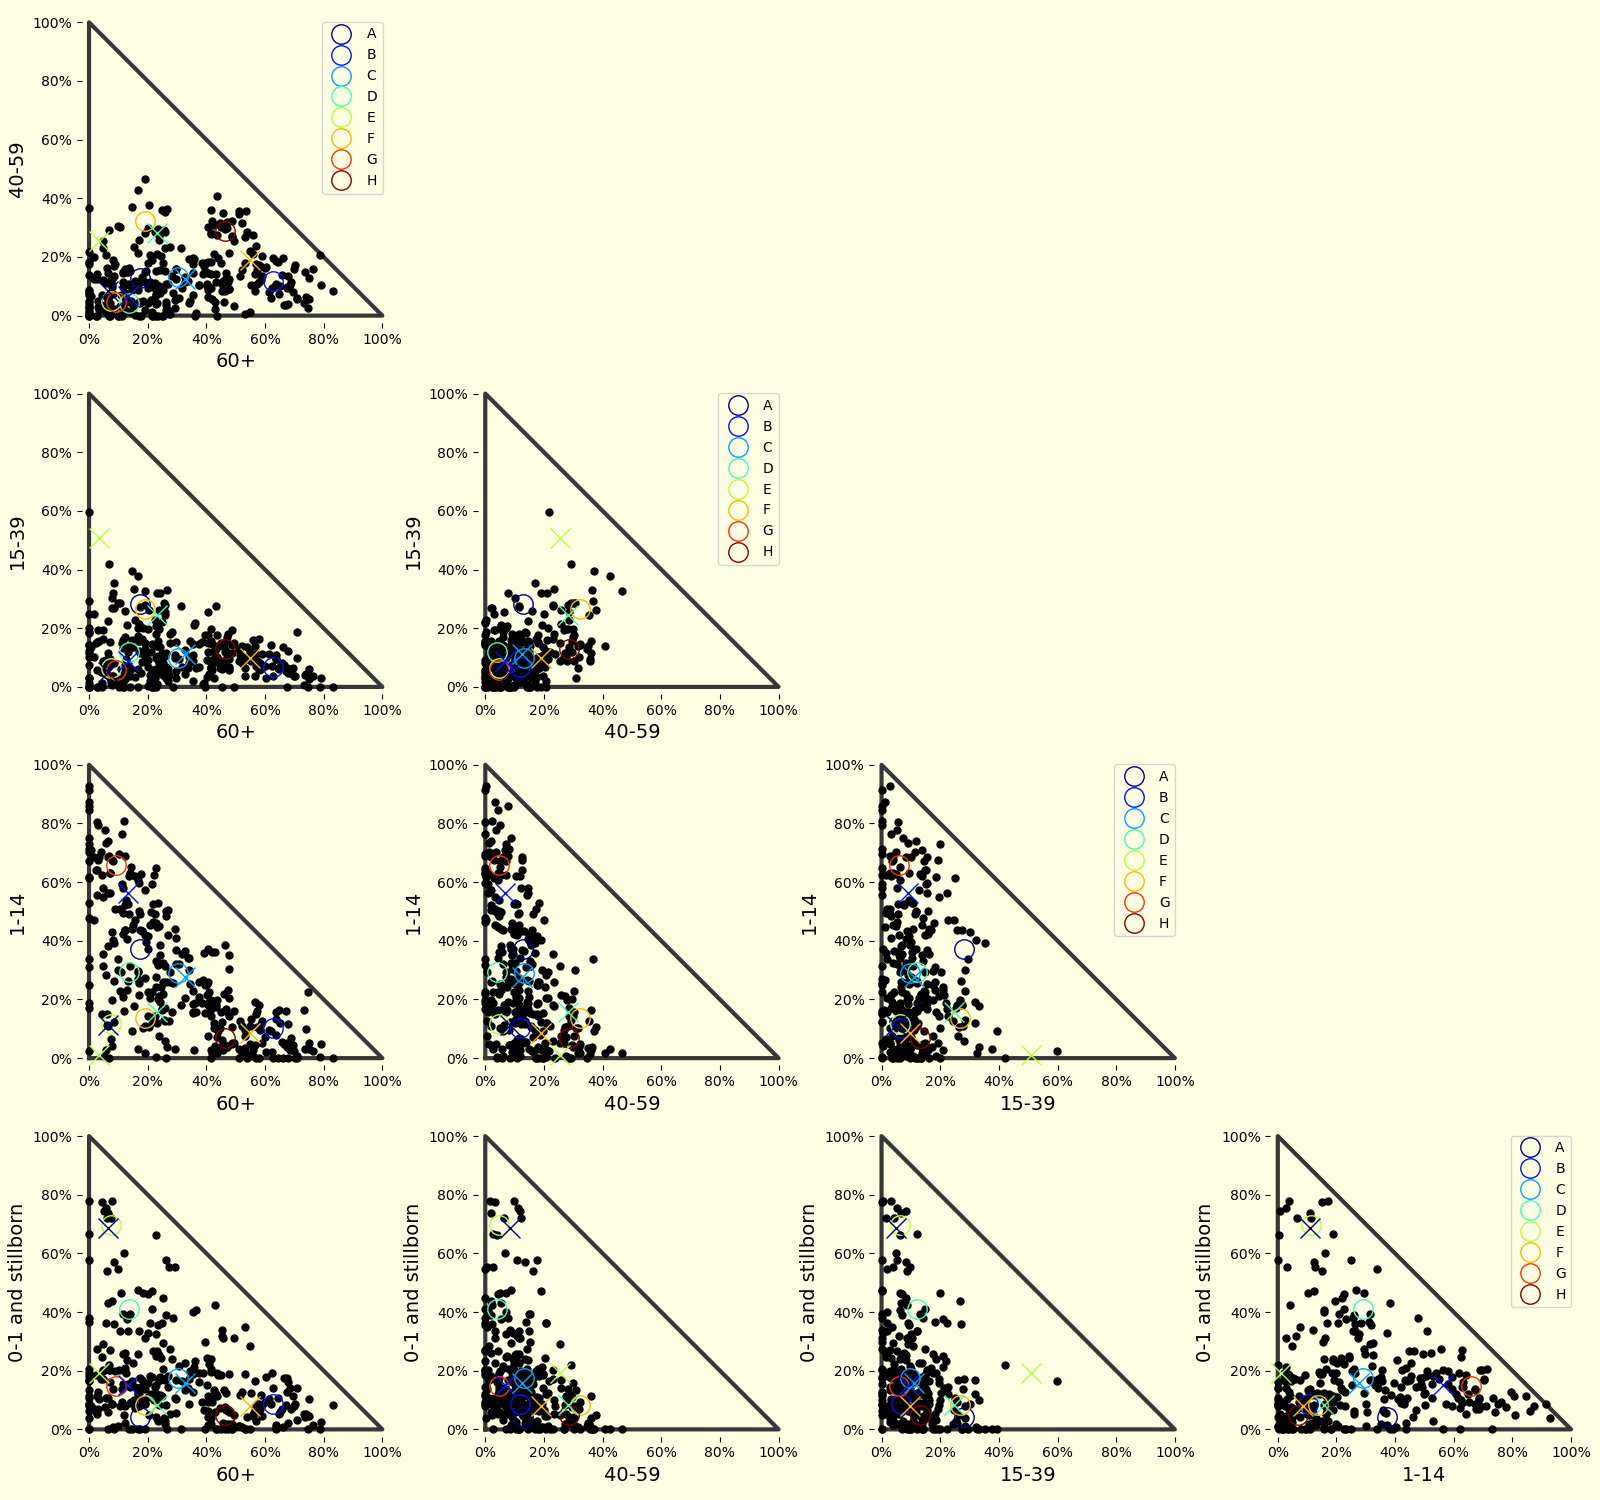

In [ ]:
fig,allAxes = plt.subplots(4,4,sharex=True,sharey=True,figsize=(16,15))
# fig,allAxes = plt.subplots(5,5)

showLabels = True
showLabels = False

for ax in allAxes.flatten():
    ax.set_aspect('equal', adjustable='box')

# for i,r in dfCrises.iloc[:40].iterrows():
# for i,r in dfCrisesLabel.iloc[:len(curDataShort)].iterrows():
for i,r in dfCrises.iterrows():
# for i,r in dfCrisesLabel.iloc[:30].iterrows():

    # (cur1,cur2,cur3,cur4,cur5) = curDataShort[i]
    (cur1,cur2,cur3,cur4,cur5) = (100*curData[i])

    curLabel = r.Amt[:4]+', '+str(r.DayWithMostBurials.year)
    # curColor = cmap(r.Cluster/numClusters)
    # curColor = cmap(curSortIndex[r.Cluster]/numClusters)
    # curColor = cmap(clusterNumDict[r.Cluster]/numClusters)
    # curColor = cmap(clusterNumDict[invMap[r.Cluster]]/numClusters)
    curColor = 'k'
    
    # curSortIndex
    # curColor = r.Disease
    # curLabel = r.Disease

    allAxes[0,0].plot(cur5,cur4,'.',color=curColor)

    allAxes[1,0].plot(cur5,cur3,'.',color=curColor)
    allAxes[1,1].plot(cur4,cur3,'.',color=curColor)
    
    allAxes[2,0].plot(cur5,cur2,'.',color=curColor)
    allAxes[2,1].plot(cur4,cur2,'.',color=curColor)
    allAxes[2,2].plot(cur3,cur2,'.',color=curColor)
    
    allAxes[3,0].plot(cur5,cur1,'.',color=curColor)
    allAxes[3,1].plot(cur4,cur1,'.',color=curColor)
    allAxes[3,2].plot(cur3,cur1,'.',color=curColor)
    allAxes[3,3].plot(cur2,cur1,'.',color=curColor)

    
    if showLabels:
        allAxes[0,0].text(cur5,cur4,curLabel,rotation=30,fontsize=6)
    
labelFontSize = 14
# allAxes[3,4].set_xlabel('Infants and stillborn',fontsize=labelFontSize)
allAxes[3,3].set_xlabel('1-14',fontsize=labelFontSize)
allAxes[2,2].set_xlabel('15-39',fontsize=labelFontSize)
allAxes[3,2].set_xlabel('15-39',fontsize=labelFontSize)
allAxes[1,1].set_xlabel('40-59',fontsize=labelFontSize)
allAxes[2,1].set_xlabel('40-59',fontsize=labelFontSize)
allAxes[3,1].set_xlabel('40-59',fontsize=labelFontSize)
allAxes[0,0].set_xlabel('60+',fontsize=labelFontSize)
allAxes[1,0].set_xlabel('60+',fontsize=labelFontSize)
allAxes[2,0].set_xlabel('60+',fontsize=labelFontSize)
allAxes[3,0].set_xlabel('60+',fontsize=labelFontSize)

# allAxes[3,0].set_ylabel('Infants and stillborn',fontsize=labelFontSize)
# allAxes[3,1].set_ylabel('Infants and stillborn',fontsize=labelFontSize)
# allAxes[3,2].set_ylabel('Infants and stillborn',fontsize=labelFontSize)
# allAxes[3,3].set_ylabel('Infants and stillborn',fontsize=labelFontSize)
allAxes[3,0].set_ylabel('0-1 and stillborn',fontsize=labelFontSize)
allAxes[3,1].set_ylabel('0-1 and stillborn',fontsize=labelFontSize)
allAxes[3,2].set_ylabel('0-1 and stillborn',fontsize=labelFontSize)
allAxes[3,3].set_ylabel('0-1 and stillborn',fontsize=labelFontSize)
allAxes[2,0].set_ylabel('1-14',fontsize=labelFontSize)
allAxes[2,1].set_ylabel('1-14',fontsize=labelFontSize)
allAxes[2,2].set_ylabel('1-14',fontsize=labelFontSize)
allAxes[1,0].set_ylabel('15-39',fontsize=labelFontSize)
allAxes[1,1].set_ylabel('15-39',fontsize=labelFontSize)
allAxes[0,0].set_ylabel('40-59',fontsize=labelFontSize)
# allAxes[3,0].set_ylabel('60+',fontsize=labelFontSize)

allAxes[0,1].axis(False)
allAxes[0,2].axis(False)
allAxes[0,3].axis(False)
allAxes[1,2].axis(False)
allAxes[1,3].axis(False)
allAxes[2,3].axis(False)


clf.means_


clusterNum = 0
# for clusterNum in range(numClusters):
for i,clusterNum in enumerate(range(gmm.means_.shape[0])):
    curMean = gmm.means_[clusterNum,:]
    # curMean = gmm.means_[curSortIndex[clusterNum],:]
    
    
    mea1,mea2,mea3,mea4,mea5 = (100*curMean)

    curColor = cmap(i/numClusters)
    curLabel = clusterNameDict[clusterNum]


    
    allAxes[0,0].plot(mea5,mea4,'o',color=curColor,mfc='none',markersize=14,label=curLabel)

    allAxes[1,0].plot(mea5,mea3,'o',color=curColor,mfc='none',markersize=14,label=curLabel)
    allAxes[1,1].plot(mea4,mea3,'o',color=curColor,mfc='none',markersize=14,label=curLabel)
    
    allAxes[2,0].plot(mea5,mea2,'o',color=curColor,mfc='none',markersize=14,label=curLabel)
    allAxes[2,1].plot(mea4,mea2,'o',color=curColor,mfc='none',markersize=14,label=curLabel)
    allAxes[2,2].plot(mea3,mea2,'o',color=curColor,mfc='none',markersize=14,label=curLabel)
    
    allAxes[3,0].plot(mea5,mea1,'o',color=curColor,mfc='none',markersize=14,label=curLabel)
    allAxes[3,1].plot(mea4,mea1,'o',color=curColor,mfc='none',markersize=14,label=curLabel)
    allAxes[3,2].plot(mea3,mea1,'o',color=curColor,mfc='none',markersize=14,label=curLabel)
    allAxes[3,3].plot(mea2,mea1,'o',color=curColor,mfc='none',markersize=14,label=curLabel)

# allAxes[0,0].legend(loc='center left',bbox_to_anchor = (1.05,0.5))
allAxes[0,0].legend()
allAxes[1,1].legend()
allAxes[2,2].legend()
allAxes[3,3].legend()

import matplotlib.ticker as ticker  

for i,clusterNum in enumerate(range(len(cluster_centers))):
    curMean = testMeans.iloc[clusterNum,:]
    
    mea1,mea2,mea3,mea4,mea5 = (100*curMean)

    curColor = cmap(i/numClusters)
    curLabel = 'MeanShift '+str(clusterNum)
    allAxes[0,0].plot(mea5,mea4,'x',color=curColor,mfc='none',markersize=14,label=curLabel)
    allAxes[1,0].plot(mea5,mea3,'x',color=curColor,mfc='none',markersize=14,label=curLabel)
    allAxes[1,1].plot(mea4,mea3,'x',color=curColor,mfc='none',markersize=14,label=curLabel)
    allAxes[2,0].plot(mea5,mea2,'x',color=curColor,mfc='none',markersize=14,label=curLabel)
    allAxes[2,1].plot(mea4,mea2,'x',color=curColor,mfc='none',markersize=14,label=curLabel)
    allAxes[2,2].plot(mea3,mea2,'x',color=curColor,mfc='none',markersize=14,label=curLabel)
    allAxes[3,0].plot(mea5,mea1,'x',color=curColor,mfc='none',markersize=14,label=curLabel)
    allAxes[3,1].plot(mea4,mea1,'x',color=curColor,mfc='none',markersize=14,label=curLabel)
    allAxes[3,2].plot(mea3,mea1,'x',color=curColor,mfc='none',markersize=14,label=curLabel)
    allAxes[3,3].plot(mea2,mea1,'x',color=curColor,mfc='none',markersize=14,label=curLabel)

    # ax1.plot(mea1,mea2,'x',color=curColor,mfc='none',markersize=14,label=curLabel)
    # ax2.plot(mea4,mea5,'x',color=curColor,mfc='none',markersize=14,label=curLabel)


for ax in allAxes.flatten():
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    # ax.plot([0,1,0,0],[0,0,1,0],color='xkcd:dark grey',zorder=0)
    ax.plot([0,100,0,0],[0,0,100,0],color='xkcd:dark grey',zorder=0)

    ax.xaxis.set_tick_params(which='both', labelbottom=True,labelsize=10)
    ax.yaxis.set_tick_params(which='both', labelbottom=True,labelsize=10)

    # ax.set_xlim([-0.01,1.01])
    # ax.set_ylim([-0.01,1.01])
    ax.set_xlim([-2.5,102.5])
    ax.set_ylim([-2.5,102.5])

    ax.xaxis.set_major_formatter(ticker.PercentFormatter())
    ax.yaxis.set_major_formatter(ticker.PercentFormatter())

    ax.grid(False)
        
allAxes[0,1].remove()
allAxes[0,2].remove()
allAxes[0,3].remove()
allAxes[1,2].remove()
allAxes[1,3].remove()
allAxes[2,3].remove()

In [ ]:
# Compare results with GMM clustering results

dfCrises
finalResultsFilename = 'AllCrises_Years12_Threshold3_LowerThreshold2_MaxDaysBelow4_minLength4_minCount50_Clustered_Grouped'
dfCrisesFinal = pd.read_csv(pathData+finalResultsFilename+'.csv')


In [ ]:


# display(dfCrisesFinal[dfCrisesFinal['Group'].str.contains('Scar')].groupby(['Cluster','Kmeans']).count())
# # display(dfCrisesFinal[dfCrisesFinal['Group'].str.contains('Scar')].groupby(['Kmeans','Cluster']).count())
# print(dfCrisesFinal[dfCrisesFinal.Cluster == 'B'].Kmeans.value_counts())
# print(dfCrisesFinal[dfCrisesFinal.Kmeans == 'D'].Cluster.value_counts())


# display(dfCrisesFinal[dfCrisesFinal['Group'].str.contains('Chol')].groupby(['Cluster','Kmeans']).count())
# # display(dfCrisesFinal[dfCrisesFinal['Group'].str.contains('Scar')].groupby(['Kmeans','Cluster']).count())
# print(dfCrisesFinal[dfCrisesFinal.Cluster == 'F'].Kmeans.value_counts())
# print(dfCrisesFinal[dfCrisesFinal.Kmeans == 'H'].Cluster.value_counts())


# display(dfCrisesFinal[dfCrisesFinal['Group'].str.contains('Pandemi')].groupby(['Cluster','Kmeans']).count())
# # display(dfCrisesFinal[dfCrisesFinal['Group'].str.contains('Scar')].groupby(['Kmeans','Cluster']).count())
# print(dfCrisesFinal[dfCrisesFinal.Cluster == 'G'].Kmeans.value_counts())
# print(dfCrisesFinal[dfCrisesFinal.Kmeans == 'G'].Cluster.value_counts())

# # display(dfCrisesFinal[dfCrisesFinal['Group'].str.contains('')].groupby(['Cluster','Kmeans']).count())
# dfCrisesFinal.groupby(['Cluster','Kmeans']).count()

Amt  Start  End  NumberOfDays  DayWithMostBurials  Excess  \
Cluster Kmeans                                                              
A       F        14     14   14            14                  14      14   
B       A         1      1    1             1                   1       1   
        C         2      2    2             2                   2       2   
        D        54     54   54            54                  54      54   
C       A        31     31   31            31                  31      31   
        F         3      3    3             3                   3       3   
        G         1      1    1             1                   1       1   
D       A         6      6    6             6                   6       6   
        C        41     41   41            41                  41      41   
        G         6      6    6             6                   6       6   
E       B         4      4    4             4                   4       4   
        E         4      4    4             4                   4       4   
        G        46     46   46            46                  46      46   
F       C         2      2    2             2                   2       2   
        G         1      1    1             1                   1       1   
        H        25     25   25            25                  25      25   
G       E        50     50   50            50                  50      50   
H       B        29     29   29            29                  29      29   

                ExcessPct  GenderRatio  TimeOfYear  Season  \
Cluster Kmeans                                               
A       F              14           14          14      14   
B       A               1            1           1       1   
        C               2            2           2       2   
        D              54           54          54      54   
C       A              31           31          31      31   
        F               3            3           3       3   
        G               1            1           1       1   
D       A               6            6           6       6   
        C              41           41          41      41   
        G               6            6           6       6   
E       B               4            4           4       4   
        E               4            4           4       4   
        G              46           46          46      46   
F       C               2            2           2       2   
        G               1            1           1       1   
        H              25           25          25      25   
G       E              50           50          50      50   
H       B              29           29          29      29   

                PopulationEstimate  Exc_Infants_stillborn  Exc_1-14  \
Cluster Kmeans                                                        
A       F                       14                     14        14   
B       A                        1                      1         1   
        C                        2                      2         2   
        D                       52                     54        54   
C       A                       30                     31        31   
        F                        3                      3         3   
        G                        1                      1         1   
D       A                        4                      6         6   
        C                       39                     41        41   
        G                        5                      6         6   
E       B                        4                      4         4   
        E                        4                      4         4   
        G                       45                     46        46   
F       C                        2                      2         2   
        G                        1                      1         1   
        H                  

In [ ]:
# dfCrises
dfCrisesFinal['MeanShiftLabel'] = allLabels


In [ ]:
dfCrisesFinal.MeanShiftLabel.value_counts()
# dfCrisesFinal.Cluster.value_counts()

0    92
1    89
2    52
4    29
3    29
6    17
5    10
7     1
8     1
Name: MeanShiftLabel, dtype: int64

In [ ]:
colsToShow = ['Amt','DayWithMostBurials','Group','Cluster','MeanShiftLabel']

dfCrisesFinal[dfCrisesFinal['Group'].str.contains('Child')][colsToShow]


display(dfCrisesFinal[dfCrisesFinal['Group'].str.contains('Scar')].groupby(['Cluster','MeanShiftLabel']).count())
# display(dfCrisesFinal[dfCrisesFinal['Group'].str.contains('Scar')].groupby(['MeanShiftLabel','Cluster']).count())
print(dfCrisesFinal[dfCrisesFinal.Cluster == 'B'].MeanShiftLabel.value_counts())
print(dfCrisesFinal[dfCrisesFinal.MeanShiftLabel == 1].Cluster.value_counts())

display(dfCrisesFinal[dfCrisesFinal['Group'].str.contains('Pandemi')].groupby(['Cluster','MeanShiftLabel']).count())
# display(dfCrisesFinal[dfCrisesFinal['Group'].str.contains('Scar')].groupby(['MeanShiftLabel','Cluster']).count())
print(dfCrisesFinal[dfCrisesFinal.Cluster == 'G'].MeanShiftLabel.value_counts())
print(dfCrisesFinal[dfCrisesFinal.MeanShiftLabel == 0].Cluster.value_counts())

,,Amt,Start,End,NumberOfDays,DayWithMostBurials,Excess,ExcessPct,GenderRatio,TimeOfYear,Season,PopulationEstimate,Exc_Infants_stillborn,Exc_1-14,Exc_15-39,Exc_40-59,Exc_60+,Pct_Infants_stillborn,Pct_1-14,Pct_15-39,Pct_40-59,Pct_60+,DataSum_Infants_stillborn,DataSum_1-14,DataSum_15-39,DataSum_40-59,DataSum_60+,Baseline_Infants_stillborn,Baseline_1-14,Baseline_15-39,Baseline_40-59,Baseline_60+,FracAll_Infants_stillborn,FracAll_1-14,FracAll_15-39,FracAll_40-59,FracAll_60+,AgeSplitSumExc,ClusterA_Prob,ClusterB_Prob,ClusterC_Prob,ClusterD_Prob,ClusterE_Prob,ClusterF_Prob,ClusterG_Prob,ClusterH_Prob,Group,AfProp
Cluster,MeanShiftLabel,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
B,1,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13
C,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
E,2,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3


1    57
Name: MeanShiftLabel, dtype: int64
B    57
D    31
C     1
Name: Cluster, dtype: int64


Amt  Start  End  NumberOfDays  DayWithMostBurials  \
Cluster MeanShiftLabel                                                      
E       0                 2      2    2             2                   2   
        2                 3      3    3             3                   3   
G       0                29     29   29            29                  29   

                        Excess  ExcessPct  GenderRatio  TimeOfYear  Season  \
Cluster MeanShiftLabel                                                       
E       0                    2          2            2           2       2   
        2                    3          3            3           3       3   
G       0                   29         29           29          29      29   

                        PopulationEstimate  Exc_Infants_stillborn  Exc_1-14  \
Cluster MeanShiftLabel                                                        
E       0                                2                      2         2   
        2                                3                      3         3   
G       0                               28                     29        29   

                        Exc_15-39  Exc_40-59  Exc_60+  Pct_Infants_stillborn  \
Cluster MeanShiftLabel                                                         
E       0                       2          2        2                      2   
        2                       3          3        3                      3   
G       0                      29         29       29                     29   

                        Pct_1-14  Pct_15-39  Pct_40-59  Pct_60+  \
Cluster MeanShiftLabel                                            
E       0                      2          2          2        2   
        2                      3          3          3        3   
G       0                     29         29         29       29   

                        DataSum_Infants_stillborn  DataSum_1-14  \
Cluster MeanShiftLabel                                            
E       0                                       2             2   
        2                                       3             3   
G       0                                      29            29   

                        DataSum_15-39  DataSum_40-59  DataSum_60+  \
Cluster MeanShiftLabel                                              
E       0                           2              2            2   
        2                           3              3            3   
G       0                          29             29           29   

                        Baseline_Infants_stillborn  Baseline_1-14  \
Cluster MeanShiftLabel                                              
E       0                                        2              2   
        2                                        3              3   
G       0                                       29             29   

                        Baseline_15-39  Baseline_40-59  Baseline_60+  \
Cluster MeanShiftLabel                                                 
E       0                            2               2             2   
        2                            3               3             3   
G       0                           29              29            29   

                        FracAll_Infants_stillborn  FracAll_1-14  \
Cluster MeanShiftLabel                                            
E       0                                       2             2   
        2                                       3             3   
G       0                                      29            29   

                        FracAll_15-39  FracAll_40-59  FracAll_60+  \
Cluster MeanShiftLabel                                              
E       0                           2              2            2   
        2                           3              3            3   
G       0                          29             29           29   

                        AgeSplitSumExc  Clu

0    50
Name: MeanShiftLabel, dtype: int64
G    50
H    29
E    13
Name: Cluster, dtype: int64


In [ ]:
print('Cholera')
print(dfCrisesFinal[dfCrisesFinal.Cluster == 'F'].MeanShiftLabel.value_counts())
print(dfCrisesFinal[dfCrisesFinal.MeanShiftLabel == 4].Cluster.value_counts())

print('Pandemic Flu')
print(dfCrisesFinal[dfCrisesFinal.Cluster == 'G'].MeanShiftLabel.value_counts())
print(dfCrisesFinal[dfCrisesFinal.MeanShiftLabel == 0].Cluster.value_counts())

print('Scalatina')
print(dfCrisesFinal[dfCrisesFinal.Cluster == 'B'].MeanShiftLabel.value_counts())
print(dfCrisesFinal[dfCrisesFinal.MeanShiftLabel == 1].Cluster.value_counts())


print('Child')
print(dfCrisesFinal[dfCrisesFinal.Cluster == 'D'].MeanShiftLabel.value_counts())
print(dfCrisesFinal[dfCrisesFinal.MeanShiftLabel == 1].Cluster.value_counts())


Cholera
4    26
7     1
8     1
Name: MeanShiftLabel, dtype: int64
F    26
E     2
D     1
Name: Cluster, dtype: int64
Pandemic Flu
0    50
Name: MeanShiftLabel, dtype: int64
G    50
H    29
E    13
Name: Cluster, dtype: int64
Scalatina
1    57
Name: MeanShiftLabel, dtype: int64
B    57
D    31
C     1
Name: Cluster, dtype: int64
Child
1    31
2    13
3     8
4     1
Name: MeanShiftLabel, dtype: int64
B    57
D    31
C     1
Name: Cluster, dtype: int64


In [ ]:
dfCrisesFinal.groupby(['Group','Cluster','MeanShiftLabel']).count()
# dfCrisesFinal.groupby(['Cluster','MeanShiftLabel','Group']).count()
# dfCrisesFinal.groupby(['Cluster','MeanShiftLabel'],as_index=False).size()
# dfCrisesFinal.groupby(['MeanShiftLabel','Cluster'],as_index=False).size()
# dfCrisesFinal.groupby(['MeanShiftLabel','Cluster','Group']).count()
# dfCrisesFinal.groupby(['MeanShiftLabel','Cluster']).count()
# dfCrisesFinal[dfCrisesFinal['Group'] != 'None'].groupby(['MeanShiftLabel','Cluster']).count()

Amt  Start  End  \
Group                    Cluster MeanShiftLabel                    
Child mortality 1829     D       1                 7      7    7   
                                 2                 2      2    2   
                                 3                 2      2    2   
                         E       2                 3      3    3   
                         F       4                 2      2    2   
                         G       0                 2      2    2   
                         H       0                 1      1    1   
Cholera (1853)           F       4                 6      6    6   
Cholera (1857)           F       4                 1      1    1   
Harvest-epidemics        D       2                 1      1    1   
                         E       2                 1      1    1   
                         F       4                 7      7    7   
                         G       0                 1      1    1   
                         H       0                20     20   20   
None                     A       5                10     10   10   
                                 6                 4      4    4   
                         B       1                41     41   41   
                         C       3                15     15   15   
                                 6                13     13   13   
                         D       1                20     20   20   
                                 2                 8      8    8   
                                 3                 5      5    5   
                                 4                 1      1    1   
                         E       0                11     11   11   
                                 2                28     28   28   
                                 4                 1      1    1   
                         F       4                 7      7    7   
                                 7                 1      1    1   
                         G       0                18     18   18   
                         H       0                 7      7    7   
Pandemic Flu (1891/1892) E       2                 2      2    2   
                         G       0                19     19   19   
Pandemic flu (1900)      E       0                 2      2    2   
                                 2                 1      1    1   
                         G       0                10     10   10   
Potentially war-related  B       1                 3      3    3   
                         C       3                 6      6    6   
                         D       1                 4      4    4   
                                 2                 2      2    2   
                                 3                 1      1    1   
                         E       2                 1      1    1   
                                 4                 1      1    1   
                         F       4                 3      3    3   
                                 8                 1      1    1   
                         H       0                 1      1    1   
Scarlatina               B       1                13     13   13   
                         C       1                 1      1    1   
                         E       2                 3      3    3   

                                                 NumberOfDays  \
Group                    Cluster MeanShiftLabel                 
Child mortality 1829     D       1                          7   
                                 2                          2   
                                 3                          2   
                         E       2                          3   
                         F       4                          2   
                         G       0                          2   
                         H       0                          1   
Cholera (1853)           F       4                          6  

In [ ]:


pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('display.min_rows', 50)


In [ ]:
# dfCrisesFinal.head(40)


# Test with affinitypropagation

In [ ]:

from sklearn.cluster import AffinityPropagation
af = AffinityPropagation(preference=-1, random_state=0).fit(curData)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_
np.unique(labels)



array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int64)

In [ ]:
dfCrisesFinal['AfProp'] = labels

In [ ]:
dfCrisesFinal.groupby(['Group','Cluster','AfProp']).count()
dfCrisesFinal.groupby(['Cluster','AfProp','Group']).count()
# dfCrisesFinal.groupby(['Cluster','AfProp'],as_index=False).size()
# dfCrisesFinal.groupby(['AfProp','Cluster'],as_index=False).size()
# dfCrisesFinal.groupby(['AfProp','Cluster','Group']).count()
# dfCrisesFinal.groupby(['AfProp','Cluster']).count()
# dfCrisesFinal[dfCrisesFinal['Group'] != 'None'].groupby(['AfProp','Cluster']).count()
dfCrisesFinal[dfCrisesFinal['Group'].str.contains('Harves')].groupby(['Cluster','AfProp']).count()

Amt  Start  End  NumberOfDays  DayWithMostBurials  Excess  \
Cluster AfProp                                                              
D       6         1      1    1             1                   1       1   
E       6         1      1    1             1                   1       1   
F       3         4      4    4             4                   4       4   
        6         3      3    3             3                   3       3   
G       1         1      1    1             1                   1       1   
H       0        20     20   20            20                  20      20   

                ExcessPct  GenderRatio  TimeOfYear  Season  \
Cluster AfProp                                               
D       6               1            1           1       1   
E       6               1            1           1       1   
F       3               4            4           4       4   
        6               3            3           3       3   
G       1               1            1           1       1   
H       0              20           20          20      20   

                PopulationEstimate  Exc_Infants_stillborn  Exc_1-14  \
Cluster AfProp                                                        
D       6                        1                      1         1   
E       6                        1                      1         1   
F       3                        4                      4         4   
        6                        3                      3         3   
G       1                        1                      1         1   
H       0                       19                     20        20   

                Exc_15-39  Exc_40-59  Exc_60+  Pct_Infants_stillborn  \
Cluster AfProp                                                         
D       6               1          1        1                      1   
E       6               1          1        1                      1   
F       3               4          4        4                      4   
        6               3          3        3                      3   
G       1               1          1        1                      1   
H       0              20         20       20                     20   

                Pct_1-14  Pct_15-39  Pct_40-59  Pct_60+  \
Cluster AfProp                                            
D       6              1          1          1        1   
E       6              1          1          1        1   
F       3              4          4          4        4   
        6              3          3          3        3   
G       1              1          1          1        1   
H       0             20         20         20       20   

                DataSum_Infants_stillborn  DataSum_1-14  DataSum_15-39  \
Cluster AfProp                                                           
D       6                               1             1              1   
E       6                               1             1              1   
F       3                               4             4              4   
        6                               3             3              3   
G       1                               1             1              1   
H       0                              20            20             20   

                DataSum_40-59  DataSum_60+  Baseline_Infants_stillborn  \
Cluster AfProp                                                           
D       6                   1            1                           1   
E       6                   1            1                           1   
F       3                   4            4                           4   
        6                   3            3                           3   
G       1                   1            1                           1   
H       0                  20           20                          20   

                Baseline_1-14  Baseline_15-39  Baseline_40-59  Baseline_60+  \
Cluster AfProp    

In [ ]:
# display(dfCrisesFinal[dfCrisesFinal['Group'].str.contains('Chol')].groupby(['Cluster','MeanShiftLabel','AfProp']).count())
# print(dfCrisesFinal[dfCrisesFinal.MeanShiftLabel == 4].AfProp.value_counts())

,,Amt,Start,End,NumberOfDays,DayWithMostBurials,Excess,ExcessPct,GenderRatio,TimeOfYear,Season,PopulationEstimate,Exc_Infants_stillborn,Exc_1-14,Exc_15-39,Exc_40-59,Exc_60+,Pct_Infants_stillborn,Pct_1-14,Pct_15-39,Pct_40-59,Pct_60+,DataSum_Infants_stillborn,DataSum_1-14,DataSum_15-39,DataSum_40-59,DataSum_60+,Baseline_Infants_stillborn,Baseline_1-14,Baseline_15-39,Baseline_40-59,Baseline_60+,FracAll_Infants_stillborn,FracAll_1-14,FracAll_15-39,FracAll_40-59,FracAll_60+,AgeSplitSumExc,ClusterA_Prob,ClusterB_Prob,ClusterC_Prob,ClusterD_Prob,ClusterE_Prob,ClusterF_Prob,ClusterG_Prob,ClusterH_Prob,Group,AfProp
Cluster,MeanShiftLabel,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
D,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
E,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
F,4,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7
G,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
H,0,20,20,20,20,20,20,20,20,20,20,19,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20


4    26
7     1
8     1
Name: MeanShiftLabel, dtype: int64
F    26
E     2
D     1
Name: Cluster, dtype: int64


# Test with DBSCAN

In [ ]:

from sklearn.cluster import DBSCAN
# 

dataToUse = curData[:150]

# db = DBSCAN(eps=0.10, min_samples=10).fit(dataToUse)

# db = DBSCAN(eps=0.1, min_samples=10).fit(curData)
# labels = db.labels_
# labels

epsRange = np.linspace(0.01,0.5,100)
for eps in epsRange:
    db = DBSCAN(eps=eps, min_samples=10).fit(dataToUse)
    db

    labels = db.labels_
    print(eps,np.unique(labels))

0.01 [-1]
0.014949494949494949 [-1]
0.0198989898989899 [-1]
0.02484848484848485 [-1]
0.029797979797979796 [-1]
0.03474747474747475 [-1]
0.039696969696969696 [-1]
0.04464646464646465 [-1]
0.049595959595959596 [-1]
0.05454545454545454 [-1]
0.059494949494949496 [-1]
0.06444444444444444 [-1]
0.06939393939393938 [-1]
0.07434343434343434 [-1]
0.07929292929292929 [-1]
0.08424242424242423 [-1  0]
0.08919191919191918 [-1  0  1  2]
0.09414141414141414 [-1  0  1]
0.09909090909090908 [-1  0  1]
0.10404040404040403 [-1  0  1]
0.10898989898989898 [-1  0  1]
0.11393939393939392 [-1  0  1]
0.11888888888888888 [-1  0  1]
0.12383838383838383 [-1  0  1  2  3]
0.12878787878787878 [-1  0  1  2  3]
0.13373737373737374 [-1  0  1  2  3  4]
0.1386868686868687 [-1  0  1  2  3]
0.14363636363636365 [-1  0  1  2]
0.1485858585858586 [-1  0  1]
0.15353535353535352 [-1  0  1]
0.15848484848484848 [-1  0  1]
0.16343434343434343 [-1  0  1]
0.16838383838383839 [-1  0  1]
0.17333333333333334 [-1  0]
0.1782828282828283 [-1

# Old below

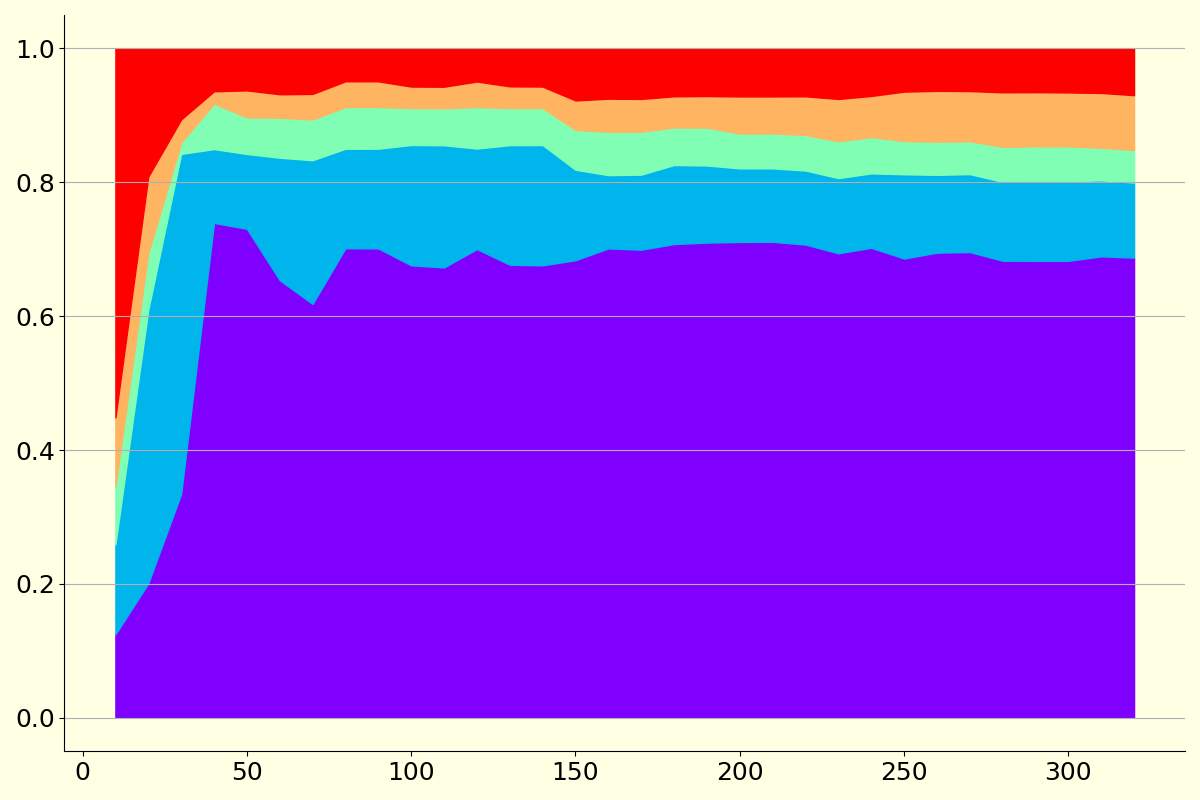

In [ ]:
# dfToPlot = dfResClust1.cumsum(axis=1)
dfToPlot = dfResClust0.cumsum(axis=1)
# dfToPlot = dfResClustLast.cumsum(axis=1)

dfToPlot = dfToPlot.astype('float')
fig,ax = plt.subplots()
# ax.plot(np.arange(len(dfToPlot)),dfToPlot[0].values)
# ax.plot(np.arange(len(dfToPlot)),dfToPlot[1].values)
ax.fill_between(curRange,dfToPlot[0],color=cmapBar(0))
ax.fill_between(curRange,dfToPlot[1],dfToPlot[0],color=cmapBar(1/5))
ax.fill_between(curRange,dfToPlot[1],dfToPlot[2],color=cmapBar(2/5))
ax.fill_between(curRange,dfToPlot[2],dfToPlot[3],color=cmapBar(3/5))
ax.fill_between(curRange,dfToPlot[3],dfToPlot[4],color=cmapBar(4/5))
# dfToPlot[0].values

In [ ]:

dlen =10 
curRange = range(10,len(curData)+dlen,dlen)
# dlen = 5
# curRange = range(150,200,dlen)
# curRange = curRange[::-1]


cmap = cm.get_cmap('jet',len(curRange)) 

# clf = mixture.GaussianMixture(n_components=numClusters, n_init = 20, covariance_type="tied",warm_start=True)

dfResClust0 = pd.DataFrame(
    index=curRange,
    columns=np.arange(5)
)
dfResClust1 = pd.DataFrame(
    index=curRange,
    columns=np.arange(5)
)
dfResClust3 = pd.DataFrame(
    index=curRange,
    columns=np.arange(5)
)
dfResClustLast = pd.DataFrame(
    index=curRange,
    columns=np.arange(5)
)
from tqdm import tqdm

numClusters = 7
clf = mixture.GaussianMixture(n_components=numClusters, n_init = 50,random_state=123,warm_start=True, covariance_type="tied")
for i,maxData in enumerate(tqdm(curRange)):
    
    curColor = cmap(i)

    dataToUse = curData[:maxData]
    # clf = mixture.GaussianMixture(n_components=numClusters, n_init = 20, covariance_type="tied")

    clf.fit(dataToUse)


    dfMeans = pd.DataFrame(clf.means_)
    # curSortIndex = dfMeans.cumsum(axis=1).sort_values(by=[0,1,2,3],ascending=False).index
    curSortIndex = dfMeans.sort_values(by=[0],ascending=False).index
    # curSortIndex = dfMeans.sort_values(by=[0,1,2,3],ascending=False).index
    dfMeans = dfMeans.loc[curSortIndex].reset_index(drop=True)
    dfResClust0.loc[maxData] = dfMeans.loc[0]
    
    # curSortIndex = dfMeans.cumsum(axis=1).sort_values(by=[0,1,2,3],ascending=False).index
    curSortIndex = dfMeans.sort_values(by=[1],ascending=False).index
    # curSortIndex = dfMeans.sort_values(by=[0,1,2,3],ascending=False).index
    dfMeans = dfMeans.loc[curSortIndex].reset_index(drop=True)
    dfResClust1.loc[maxData] = dfMeans.loc[0]
    
    # curSortIndex = dfMeans.cumsum(axis=1).sort_values(by=[0,1,2,3],ascending=False).index
    curSortIndex = dfMeans.sort_values(by=[3],ascending=False).index
    # curSortIndex = dfMeans.sort_values(by=[0,1,2,3],ascending=False).index
    dfMeans = dfMeans.loc[curSortIndex].reset_index(drop=True)
    dfResClust3.loc[maxData] = dfMeans.loc[0]

    
    curSortIndex = dfMeans.sort_values(by=[4],ascending=False).index
    # curSortIndex = dfMeans.sort_values(by=[0,1,2,3],ascending=False).index
    dfMeans = dfMeans.loc[curSortIndex].reset_index(drop=True)
    dfResClustLast.loc[maxData] = dfMeans.loc[0]
    


  0%|          | 0/32 [00:00<?, ?it/s]

100%|██████████| 32/32 [00:00<00:00, 37.03it/s]


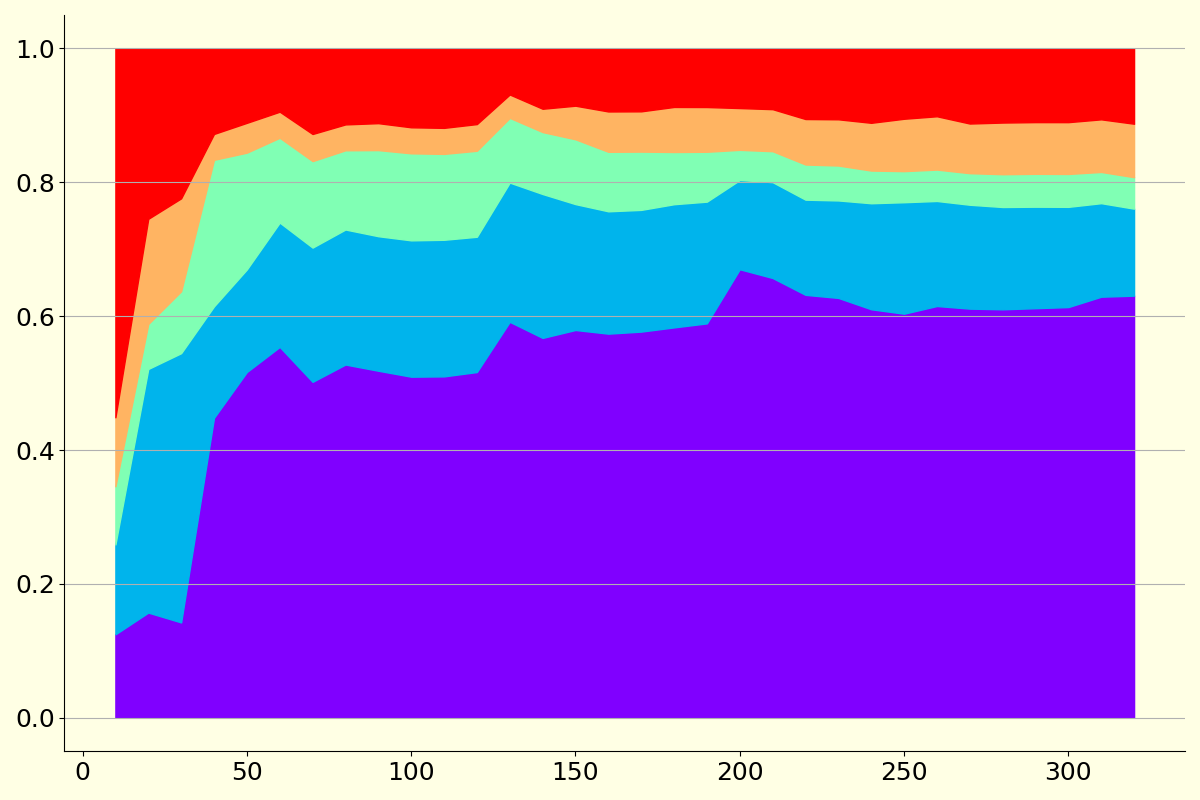

In [ ]:
dfToPlot = dfResClust0.cumsum(axis=1)
# dfToPlot = dfResClustLast.cumsum(axis=1)

dfToPlot = dfToPlot.astype('float')
fig,ax = plt.subplots()
# ax.plot(np.arange(len(dfToPlot)),dfToPlot[0].values)
# ax.plot(np.arange(len(dfToPlot)),dfToPlot[1].values)
ax.fill_between(curRange,dfToPlot[0],color=cmapBar(0))
ax.fill_between(curRange,dfToPlot[1],dfToPlot[0],color=cmapBar(1/5))
ax.fill_between(curRange,dfToPlot[1],dfToPlot[2],color=cmapBar(2/5))
ax.fill_between(curRange,dfToPlot[2],dfToPlot[3],color=cmapBar(3/5))
ax.fill_between(curRange,dfToPlot[3],dfToPlot[4],color=cmapBar(4/5))
# dfToPlot[0].values

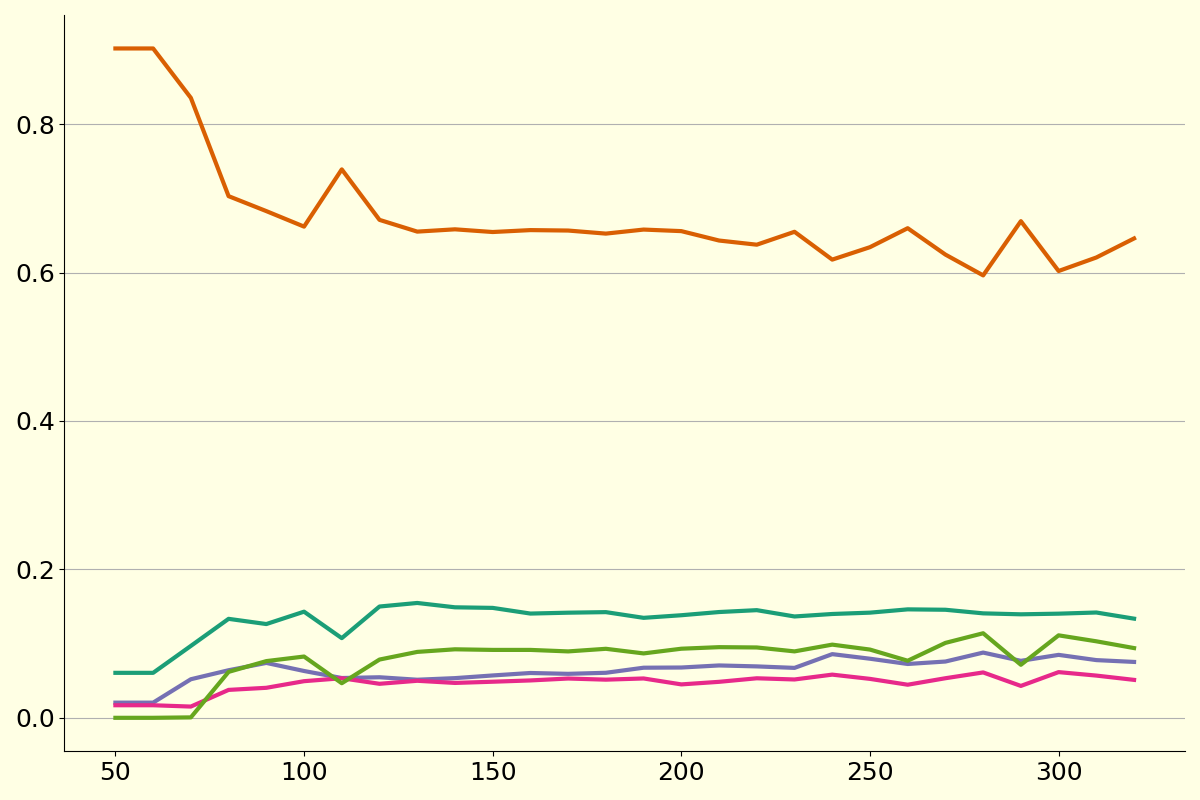

In [ ]:
fig,ax = plt.subplots()
ax.plot(dfResClust0[0])
ax.plot(dfResClust0[1])
ax.plot(dfResClust0[2])
ax.plot(dfResClust0[3])
ax.plot(dfResClust0[4])
# ax.plot(dfResClustLast[0],':')
# ax.plot(dfResClustLast[1],':')
# ax.plot(dfResClustLast[2],':')
# ax.plot(dfResClustLast[3],':')
# ax.plot(dfResClustLast[4],':')

# ax.plot(dfResClustLast[0],dfResClustLast[1],'.-')
# ax.plot(dfResClustLast[1],dfResClustLast[2],'.-')
# ax.plot(dfResClustLast[2],dfResClustLast[3],'.-')
# ax.plot(dfResClustLast[3],dfResClustLast[4],'.-')
# ax.plot(dfResClustLast[0],dfResClustLast[4],'.-')

# ax.set_xlim([0,1])
# ax.set_ylim([0,1])

In [ ]:
# dfResClust0

# Try with weights

In [ ]:
# curWeights = dfCrises['Excess']
plt.close('all')
# maxData = len(dfCrises)

In [ ]:

# fig,(ax,ax2) = plt.subplots(2,1)
# # fig,ax2 = plt.subplots(figsize=(10,5))

# dataToUse = curData
# # dataToUse = curData[:maxData]

# for numClusters in tqdm(range(2,15)):
    
#     clf = mixture.GaussianMixture(n_components=numClusters, n_init = 10,random_state=123,weights_init=curWeights, covariance_type="tied")
#     clf.fit(dataToUse)

#     ax.plot(numClusters,clf.aic(dataToUse),'D')
#     ax2.plot(numClusters,clf.bic(dataToUse),'s')

In [ ]:

# dataToUse = curData[:maxData]
# numClusters = 7
# clf = mixture.GaussianMixture(n_components=numClusters, n_init = 10,random_state=123, covariance_type="tied")

In [ ]:
# curMean = clf.means_
# dfMeans = pd.DataFrame(clf.means_)

# # Sort clusters by the sum of first and second columns (i.e. stillborn+0+1-14)
# curSortIndex = dfMeans[[0,1]].sum(axis=1).sort_values(ascending=False).index
# dfMeans = dfMeans.loc[curSortIndex]
# dfMeans